In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import boxcox
from scipy.stats import norm
from scipy.stats import probplot
from scipy.stats import spearmanr
from statsmodels.api import qqplot, add_constant

from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score, f1_score, log_loss,\
classification_report, roc_curve, confusion_matrix
from sklearn.dummy import DummyClassifier

from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.inspection import permutation_importance
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor

import random
from tqdm import tqdm
import joblib

In [2]:
RND_STATE = 777

In [3]:
datasets_names = ["Тренировочный", "Валидационный", "Контрольный"]
datasets_path = ["Train_wo_na.csv", "Valid_wo_na.csv", "Control_wo_na.csv"]

train = pd.read_csv(fr'Data\{datasets_path[0]}', encoding='cp1251', index_col=0)
valid = pd.read_csv(fr'Data\{datasets_path[1]}', encoding='cp1251', index_col=0)
test = pd.read_csv(fr'Data\{datasets_path[2]}', encoding='cp1251', index_col=0)

datasets = [train, valid, test]

На данном этапе нам необходимо подготовить данные для обучения модели логистической регрессии. Для этого нам необходимо провести следующие операции: 

* Предварительно можно создать дополнительные фичи

1) приведем количественные признаки к нормальному распределению; 

2) выполним масштабирование количественных данных; 

3) применим кодировщик для категориальных данных;

4) отберем признаки (уменьшим размерность).

# Нормализация распределения количественных переменных

В отличие от линейной регрессии, логистическая регрессия не полагается на предположение о нормальном распределении. Однако, решение может стать более стабильным, если распределение предикторов будет многомерным нормальным.

Для этого можно применить преобразование Бокса-Кокса для количественных столбцов.

Однако, стоит помнить, что **$\lambda$ берется с обучающих данных и с ее помощью преобразуются тестовые и контрольные данные**.

In [4]:
quant_cols = train.dtypes[(train.dtypes == int) | (train.dtypes == float)].index

Преобразование Бокса-Кокса требует от данных положительного знака.
$$y = \{ y_1, \ldots, y_n \}, \quad y_i > 0, \quad i = 1,\ldots,n$$

$$y_i^{\lambda} = \begin{cases}\frac{y_i^\lambda - 1}{\lambda};\text{если } \lambda \neq 0,\\ \log{(y_i)}; \text{если } \lambda = 0.\end{cases}$$ 
Можно посмотреть, в каких предикторах у нас имеются отрицательные значения.

In [6]:
(train[quant_cols] <= 0).sum()

age                          0
credit_sum                   0
score_shk                    2
monthly_income               0
credit_count             24494
overdue_credit_count    114365
month_payment                0
payment_income_part          0
dtype: int64

In [7]:
for col in ['score_shk', 'credit_count', 'overdue_credit_count']:
    print(f'{col} {train[train[col] <= 0][col].unique()}')

score_shk [0.]
credit_count [ 0. -1.]
overdue_credit_count [ 0. -1.]


Таким образом, в колонке `score_shk` у нас присутствует одно значение равное 0, в колонках `credit_count` и `overdue_credit_count` есть два значения, 0 - нет кредитов данной категории, а -1 означает, что нет информации по данной переменной. Можно прибавить к данным колонкам 0.0001 и 1.0001 соответственно.

Также можно добавить колонки, отражающие наличие пропусков в `credit_count` и `overdue_credit_count`, далее мы все равно проведем дамми-кодирование новых переменных.

In [8]:
for col in tqdm(['credit_count', 'overdue_credit_count']):
    for df in datasets:
        df[col + '_na'] = np.where((df[col] == -1), 1, 0).astype('object')

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.55it/s]


In [9]:
for col in tqdm(['credit_count', 'overdue_credit_count']):
    for df in datasets:
        df[col] = df[col] + 1.0001
        
for df in datasets:
    df['score_shk'] = df['score_shk'] + 0.0001

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 398.64it/s]


In [10]:
(train[quant_cols] <= 0).sum()
# Теперь у нас нет отрицательных и нулевых значений

age                     0
credit_sum              0
score_shk               0
monthly_income          0
credit_count            0
overdue_credit_count    0
month_payment           0
payment_income_part     0
dtype: int64

In [11]:
quant_cols =['age', 'credit_sum', 'monthly_income',
             'credit_count', 'overdue_credit_count', 'score_shk',
             'month_payment', 'payment_income_part']

Lambda for age: -0.318
Lambda for credit_sum: 0.038
Lambda for monthly_income: -0.146
Lambda for credit_count: 0.520
Lambda for overdue_credit_count: 0.935
Lambda for score_shk: 0.644
Lambda for month_payment: -0.068
Lambda for payment_income_part: 0.148


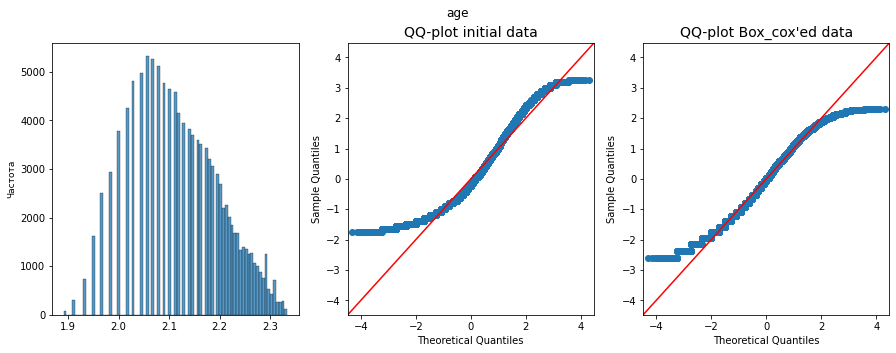

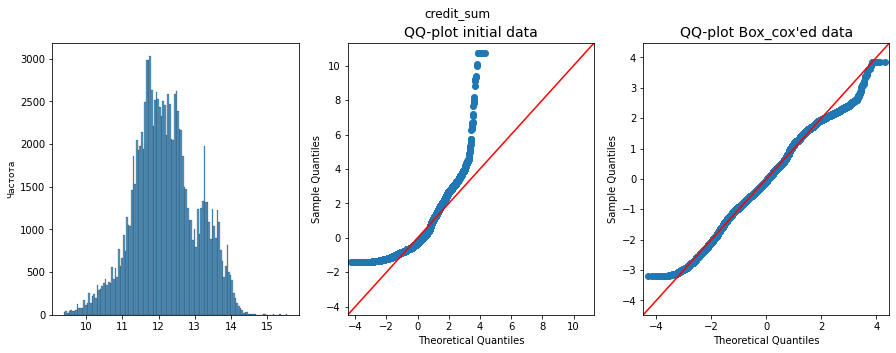

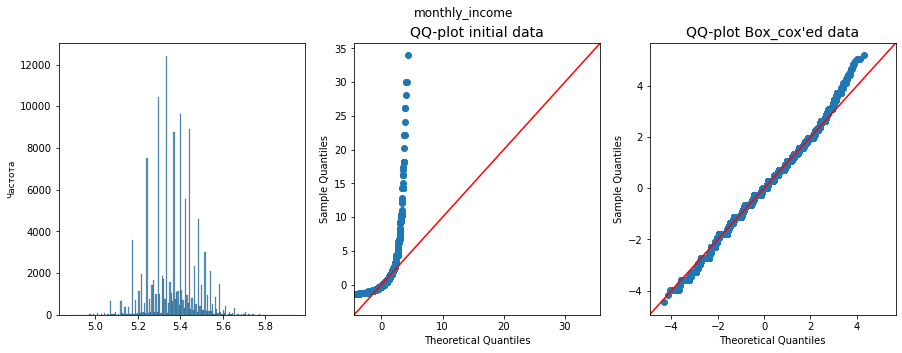

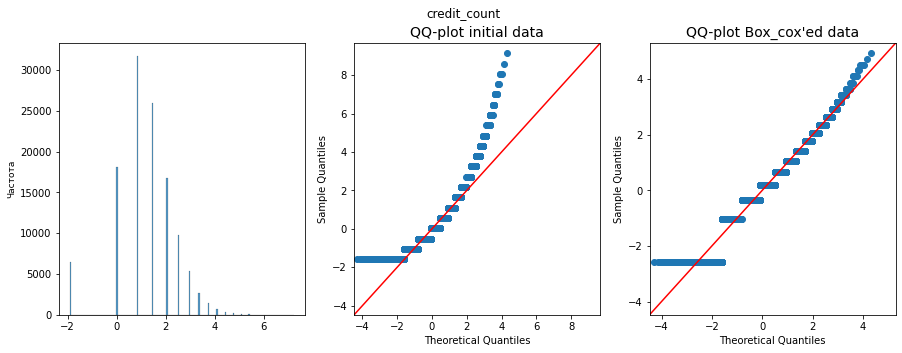

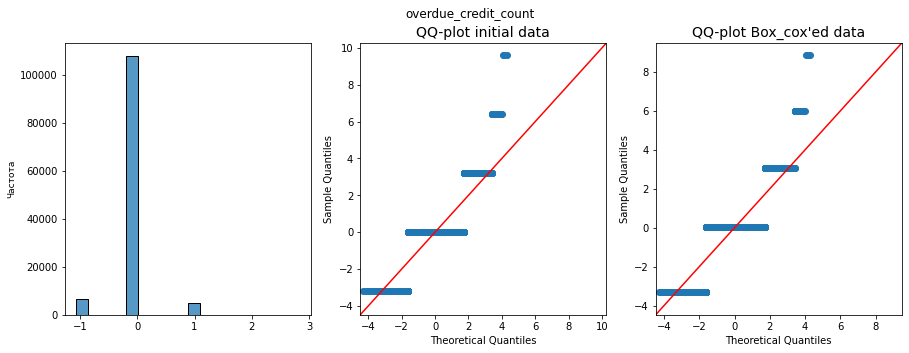

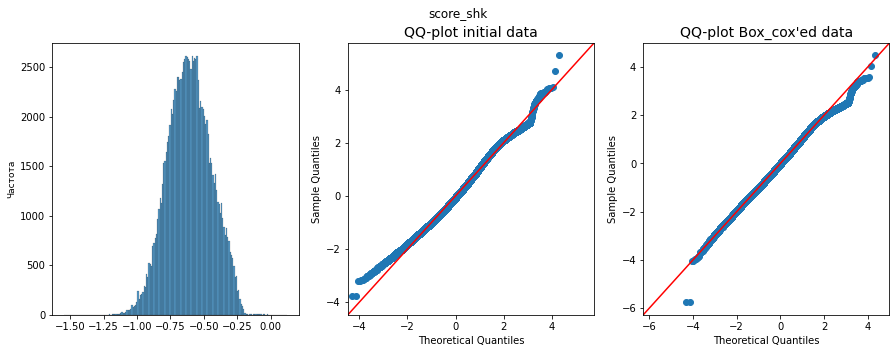

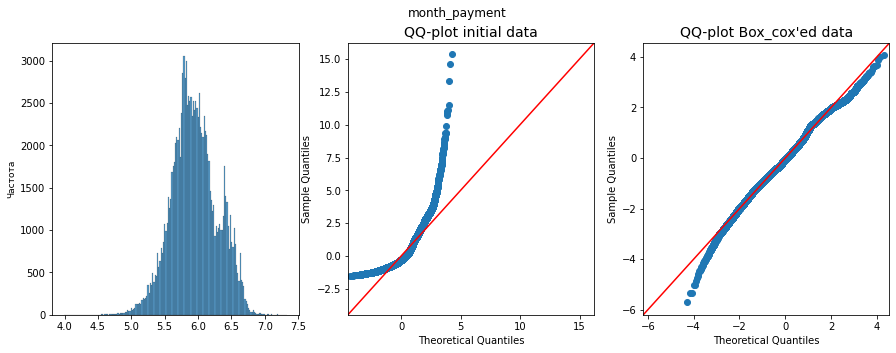

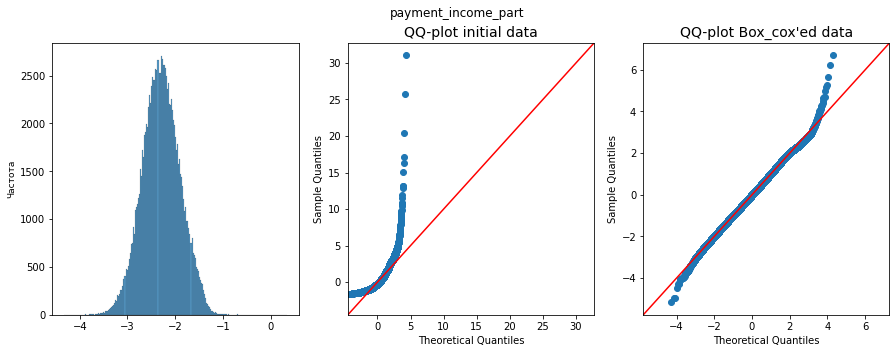

In [12]:
for col in quant_cols:
    transformed, lam = boxcox(train[col])
    print(f'Lambda for {col}: {lam:.3f}')

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    sns.histplot(transformed, ax=ax[0])
    qqplot(train[col], norm, fit=True, line='45', ax=ax[1])
    qqplot(transformed, norm, fit=True, line='45', ax=ax[2])

    ax[0].set_ylabel('Частота', fontsize=9)
    ax[1].set_title("QQ-plot initial data", fontsize=14)
    ax[2].set_title("QQ-plot Box_cox'ed data", fontsize=14)
    fig.suptitle(col)

Можно заметить, что преобразование Бокса-Кокса не обязательно для `credit_count`, `overdue_credit_count`, `score_shk`, поскольку не приводит к значимому улучшению вида распределения переменной. Таким образом, нам надо преобразовать колонки `age`, `credit_sum`, `monthly_income`. Во избежание нулевых значений в тестовом и контрольных наборах до преобразования прибавим к ним 0.0001.

In [13]:
transformation_lambdas = {}
for col in tqdm(quant_cols):
    for ind, df in enumerate(datasets):
        df[col] = df[col] + 0.0001
        if ind == 0: # Поскольку у нас тренировочный датасет первый в списке
            df[col], lam = boxcox(df[col])    
            transformation_lambdas[col] = lam
        else:
            df[col]= boxcox(df[col], lam)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.38it/s]


In [14]:
transformation_lambdas

{'age': -0.3178831313449778,
 'credit_sum': 0.03838551579008124,
 'monthly_income': -0.14564076859225772,
 'credit_count': 0.5298297530853822,
 'overdue_credit_count': 0.9570711126311593,
 'score_shk': 0.6436609437954757,
 'month_payment': -0.06819472893275555,
 'payment_income_part': 0.14570054875925367}

In [15]:
train['monthly_income']

87470     5.285763
77449     5.295132
97073     5.336300
6498      5.336300
156564    5.513909
            ...   
83528     5.320850
138673    5.151297
141915    5.385221
35227     5.370265
125619    5.539954
Name: monthly_income, Length: 119522, dtype: float64

Проведем кодирование категориальных переменных по методу "с одним активным состоянием".

In [16]:
cat_cols = train.dtypes[train.dtypes == 'object'].index

In [17]:
train_label = pd.get_dummies(train, columns=cat_cols, drop_first=True)
valid_label = pd.get_dummies(valid, columns=cat_cols, drop_first=True)
test_label = pd.get_dummies(test, columns=cat_cols, drop_first=True)

In [18]:
X_train = train_label.drop('open_account_flg', axis=1)
y_train = train_label['open_account_flg']

X_valid = valid_label.drop('open_account_flg', axis=1)
y_valid = valid_label['open_account_flg']

X_test = test_label.drop('open_account_flg', axis=1)
y_test = test_label['open_account_flg']

Также необходимо стандартизовать данные (поскольку у нас не все предикторы имеют нормальное распределение, то лучше воспользоваться классом RobustScaler, который устойчив к выбросам).

In [19]:
scaler = RobustScaler()
scaler.fit(X_train)

X_tr_scaled = pd.DataFrame(scaler.transform(X_train.values),
                           columns=X_train.columns,
                           index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_valid.values),
                            columns=X_valid.columns,
                            index=X_valid.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                             columns=X_test.columns,
                             index=X_test.index)

In [36]:
lr_metrics = pd.DataFrame(index=['roc-auc', 'precision',
                                 'recall', 'f1', 'logloss'])

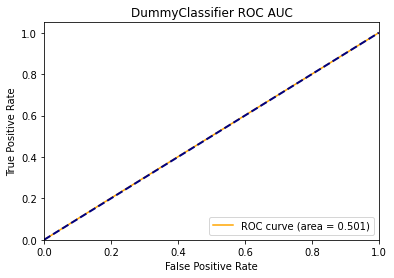

In [80]:
dummy = DummyClassifier(strategy='stratified', random_state=RND_STATE)
dummy.fit(X_tr_scaled, y_train)

y_pred = dummy.predict(X_val_scaled)
y_score = dummy.predict_proba(X_val_scaled)[:,1]
    
lr_metrics['DummyClassifier'] = [roc_auc_score(y_valid, y_score),
                              precision_score(y_valid, y_pred),
                              recall_score(y_valid, y_pred),
                              f1_score(y_valid, y_pred),
                              log_loss(y_valid, y_pred)]
    
fpr_baseline, tpr_baseline, thresholds = roc_curve(y_valid, y_score)

roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

plt.plot(fpr_baseline, tpr_baseline, color='orange',
             label=f'ROC curve (area = {roc_auc_baseline:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('DummyClassifier ROC AUC')
plt.legend(loc="lower right")
plt.show()

In [81]:
lr_metrics

,lr_baseline,lr_baseline_tuned,DummyClassifier
roc-auc,0.729256,0.729320,0.500769
precision,0.308099,0.308428,0.177318
recall,0.646085,0.645754,0.173150
f1,0.417232,0.417465,0.175209
logloss,10.972707,10.956604,9.910890


# Baseline-модель

In [37]:
def make_log_reg(x_train, y_train, x_valid, y_valid,
                 results_df, model_name, parameters={'max_iter':1500}):  
    log_reg_model =  LogisticRegression(**parameters,
                                        class_weight = 'balanced',
                                        random_state=RND_STATE)
    log_reg_model.fit(x_train, y_train)
    
    y_pred = log_reg_model.predict(x_valid)
    y_score = log_reg_model.predict_proba(x_valid)[:,1]
    
    lr_metrics[model_name] = [roc_auc_score(y_valid, y_score),
                              precision_score(y_valid, y_pred),
                              recall_score(y_valid, y_pred),
                              f1_score(y_valid, y_pred),
                              log_loss(y_valid, y_pred)]
    
    fpr_baseline, tpr_baseline, thresholds = roc_curve(y_valid, y_score)

    roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

    plt.plot(fpr_baseline, tpr_baseline, color='orange',
             label=f'ROC curve (area = {roc_auc_baseline:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Logistic Regression ROC AUC')
    plt.legend(loc="lower right")
    plt.show()
    return log_reg_model

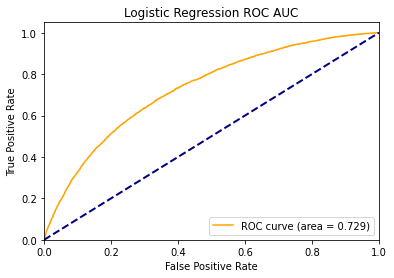

In [38]:
lr_baseline = make_log_reg(x_train=X_tr_scaled,
                           y_train=y_train,
                           x_valid=X_val_scaled,
                           y_valid=y_valid,
                           results_df=lr_metrics,
                           model_name='lr_baseline')

In [39]:
lr_metrics

,lr_baseline
roc-auc,0.729256
precision,0.308099
recall,0.646085
f1,0.417232
logloss,10.972707


# Подбор оптимальных гиперпараметров

In [175]:
def find_optimal_params(x_train, y_train, parameters_grid,
                        cv_n_splits=5, n_jobs=-1):
    lr_basic_params = {
        'class_weight':'balanced',
        'random_state':RND_STATE
    }
    
    log_reg = LogisticRegression(**lr_basic_params)
    strat_cv = StratifiedKFold(n_splits=cv_n_splits,
                               shuffle=True)
    
    grid_cv = GridSearchCV(log_reg,
                           parameters_grid,
                           scoring='roc_auc',
                           cv=strat_cv,
                           verbose=10,
                           n_jobs=n_jobs)   
    
    grid_cv.fit(x_train, y_train)
    print(f'Наилучший ROC AUC = {grid_cv.best_score_:.4f}')
    print(f'Наилучшие параметры: {grid_cv.best_params_}')
    return grid_cv

In [176]:
parameters_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.linspace(0.1, 1000, num=5),
    'solver': ['sag', 'liblinear', 'lbfgs'],
    'l1_ratio': [0.2, 0.4, 0.6, 0.8],
    'max_iter': np.arange(400, 2000, 200)
}

In [177]:
!telegram-send "grid_baseline_cv optimization started!"

In [178]:
%%time
grid_baseline_cv = find_optimal_params(x_train=X_tr_scaled,
                                       y_train=y_train,
                                       parameters_grid=parameters_grid)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


KeyboardInterrupt: 

In [179]:
!telegram-send "grid_baseline_cv optimized!"

In [180]:
baseline_best_params = grid_baseline_cv.best_params_

In [181]:
# baseline_best_params = {'C': 500.5,
#                         'l1_ratio': 0.2,
#                         'max_iter': 4000, 
#                         'penalty': 'l2', 
#                         'solver': 'lbfgs'}

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


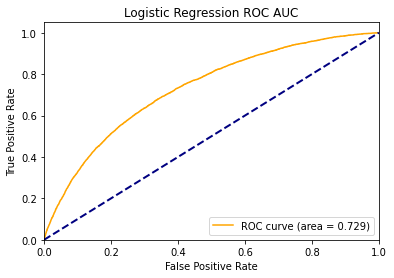

In [182]:
lr_baseline_tuned = make_log_reg(x_train=X_tr_scaled,
                                 y_train=y_train,
                                 x_valid=X_val_scaled,
                                 y_valid=y_valid,
                                 results_df=lr_metrics,
                                 parameters=best_params,
                                 model_name='lr_baseline_tuned')

In [183]:
lr_metrics[:-1].style.highlight_max(axis=1, color='lightblue')

,lr_baseline,lr_baseline_tuned,DummyClassifier,lr_baseline_wcols,lr_wcols_nocorr,lr_wcols_nocorr1,Grid_LR_ncorr,lr_denddrop
roc-auc,0.729256,0.729320,0.500769,0.740714,0.740562,0.740573,0.741452,0.740597
precision,0.308099,0.308428,0.177318,0.320084,0.318251,0.318357,0.318674,0.319704
recall,0.646085,0.645754,0.173150,0.657176,0.656679,0.656845,0.657341,0.658831
f1,0.417232,0.417465,0.175209,0.430492,0.428726,0.428857,0.429251,0.430503


Можно заметить, что производительность модели возрасла лишь слегка, что, возможно, связано с предупреждениями, которые мы получили в ходе обучения модели. Проверим первое предположение со StackOverflow о различии колонок в датасетах.

Мы получили следующее предупреждение:

*warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\глеб\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite*

На StackOverflow есть несколько мыслей по этому поводу:
1. [В проверочном и обучающем наборе есть различия в категориях, поэтому когда на проверочном датасете появляется категория, которая отсутствует в обучающем наборе, то логистическая регрессия выдает NaN.](https://stackoverflow.com/questions/66620269/i-got-the-warning-userwarning-one-or-more-of-the-test-scores-are-non-finite-w)
2. [Второе решение возможно, кроется в комбинации гиперпараметров, которые могут приводить к NaN-значениям.](https://stackoverflow.com/questions/67535904/userwarning-one-or-more-of-the-test-scores-are-non-finite-warning-only-when-a)

В первом случае необходимо проверить, что предикторы во всех наборах одинаковы, а во втором посмотреть в `grid_cv.cv_results_` сочетания гиперпараметров, которые приводят к неопределенным значениям.

Однако, для начала, можно посмотреть на показатели качества полученной с предупреждениями модели.

In [62]:
print((X_valid.columns == X_train.columns).all())
print((X_test.columns == X_train.columns).all())

True
True


Таким образом, видно, что проблема не в различных категориях.

Тогда проверим кроется ли проблема в сочетаниях гиперпараметров.

In [63]:
grid_results = pd.DataFrame(grid_cv.cv_results_)
bad_grid_results = grid_results[grid_results['split0_test_score'].isna()]

In [64]:
bad_grid_results['param_solver'].unique()
# Проблемы есть только с 'sag', 'lbfgs'

array(['sag', 'lbfgs'], dtype=object)

In [65]:
bad_grid_results[bad_grid_results['param_solver'] == 'sag'].head(6)
# Видим, что оптимизатор sag работет только с регуляризацией l2 - лассо.

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_l1_ratio,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.154262,0.001253,0.0,0.0,1.0,0.2,100,l1,sag,"{'C': 1.0, 'l1_ratio': 0.2, 'max_iter': 100, '...",NaN,NaN,NaN,NaN,NaN,747
6,0.185678,0.006632,0.0,0.0,1.0,0.2,100,elasticnet,sag,"{'C': 1.0, 'l1_ratio': 0.2, 'max_iter': 100, '...",NaN,NaN,NaN,NaN,NaN,854
9,0.147113,0.003732,0.0,0.0,1.0,0.2,200,l1,sag,"{'C': 1.0, 'l1_ratio': 0.2, 'max_iter': 200, '...",NaN,NaN,NaN,NaN,NaN,856
15,0.150771,0.003083,0.0,0.0,1.0,0.2,200,elasticnet,sag,"{'C': 1.0, 'l1_ratio': 0.2, 'max_iter': 200, '...",NaN,NaN,NaN,NaN,NaN,858
18,0.151102,0.002936,0.0,0.0,1.0,0.2,300,l1,sag,"{'C': 1.0, 'l1_ratio': 0.2, 'max_iter': 300, '...",NaN,NaN,NaN,NaN,NaN,860
24,0.149932,0.003391,0.0,0.0,1.0,0.2,300,elasticnet,sag,"{'C': 1.0, 'l1_ratio': 0.2, 'max_iter': 300, '...",NaN,NaN,NaN,NaN,NaN,862


In [66]:
bad_grid_results[bad_grid_results['param_solver'] == 'lbfgs'].head(6)
# Видим, что оптимизатор lbfgs работет только с регуляризацией l2 - лассо.

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_l1_ratio,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,0.147901,0.003274,0.0,0.0,1.0,0.2,100,l1,lbfgs,"{'C': 1.0, 'l1_ratio': 0.2, 'max_iter': 100, '...",NaN,NaN,NaN,NaN,NaN,853
8,0.152432,0.003390,0.0,0.0,1.0,0.2,100,elasticnet,lbfgs,"{'C': 1.0, 'l1_ratio': 0.2, 'max_iter': 100, '...",NaN,NaN,NaN,NaN,NaN,855
11,0.147113,0.004534,0.0,0.0,1.0,0.2,200,l1,lbfgs,"{'C': 1.0, 'l1_ratio': 0.2, 'max_iter': 200, '...",NaN,NaN,NaN,NaN,NaN,857
17,0.152765,0.002618,0.0,0.0,1.0,0.2,200,elasticnet,lbfgs,"{'C': 1.0, 'l1_ratio': 0.2, 'max_iter': 200, '...",NaN,NaN,NaN,NaN,NaN,859
20,0.147446,0.001881,0.0,0.0,1.0,0.2,300,l1,lbfgs,"{'C': 1.0, 'l1_ratio': 0.2, 'max_iter': 300, '...",NaN,NaN,NaN,NaN,NaN,861
26,0.140291,0.000940,0.0,0.0,1.0,0.2,300,elasticnet,lbfgs,"{'C': 1.0, 'l1_ratio': 0.2, 'max_iter': 300, '...",NaN,NaN,NaN,NaN,NaN,863


In [67]:
bad_grid_results['mean_score_time'].mean()

0.0

Мы также могли прийти к таким же выводам посмотрев предупреждения в ходе поиска по сетке:

*ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.*

Однако, если посмотреть на среднее время вычислений при таких комбинациях, то оно равно 0, т.е. мы не теряем в производительности поиска оптимальных гиперпараметров.

Таким образом, оптимиизация гиперпараметров не дала ощутимых результатов, следовательно, улучшение модели можно провести путем создания различных переменных, которые должны внести нелинейные взаимодействия в модель логистической регрессии.

# Добавление новых предикторов

In [82]:
datasets_path = ["Train_wo_na.csv", "Valid_wo_na.csv", "Control_wo_na.csv"]

train = pd.read_csv(fr'Data\{datasets_path[0]}', encoding='cp1251', index_col = 0).copy()
valid = pd.read_csv(fr'Data\{datasets_path[1]}', encoding='cp1251', index_col = 0).copy()
test = pd.read_csv(fr'Data\{datasets_path[2]}', encoding='cp1251', index_col = 0).copy()

datasets = [train, valid, test]

In [83]:
for col in tqdm(['credit_count', 'overdue_credit_count']):
    for df in datasets:
        df[col + '_na'] = np.where((df[col] == -1), 1, 0).astype('object')

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.32it/s]


In [84]:
for col in tqdm(['credit_count', 'overdue_credit_count']):
    for df in datasets:
        df[col] = df[col] + 1.0001
        
for df in datasets:
    df['score_shk'] = df['score_shk'] + 0.0001

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 400.58it/s]


Теперь создадим переменные - средние значения количественной переменной, взятые по уровню категориальной переменной. А также сравним показатель клиента с этим средним значением. 

Например, колонка `score_is_gt_median_education` отображает превосходит ли внутренняя скоринговая оценка клиента медианное значение для людей с таким же образованием.

In [85]:
categorical_cols = ['living_region', 'gender',
                    'marital_status', 'job_position',
                    'education']

quantitative_cols = ['age', 'credit_sum', 'credit_month',
                     'score_shk', 'monthly_income',
                     'credit_count', 'overdue_credit_count']

category_col_names = dict(zip(categorical_cols, ['region', 'gender',
                                                 'marital', 'job', 'education']))

quantitative_col_names = dict(zip(quantitative_cols, ['age','cr_sum', 'cr_month',
                                                      'score', 'income', 'cr_count',
                                                      'overdue_count']))

for category in tqdm(categorical_cols):
    for indicator in quantitative_cols:
        grouped = train.groupby(category)[indicator].agg(np.median).to_dict()
        median_col_name = category_col_names[category] + '_median_' +  quantitative_col_names[indicator]
        is_gt_median_col_name = quantitative_col_names[indicator] + '_is_gt_median_' + category_col_names[category]             
        for df in datasets:
            df[median_col_name] = df[category].map(grouped)                      
            df[is_gt_median_col_name] = np.where(df[indicator] >= df[median_col_name], '1', '0')
            df.drop(median_col_name, axis=1, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.06s/it]


In [86]:
for indicator in tqdm(quantitative_cols):
    for df in datasets:
        df[indicator + '_sq'] = df[indicator] ** 2
        df[indicator + '_inv'] = (1 / df[indicator]).replace([np.inf, -np.inf], -1)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 163.12it/s]


In [87]:
quantitative_cols = ['age', 'credit_sum', 'monthly_income',
                     'month_payment', 'payment_income_part'] + list(train.columns)[-14:]

Lambda for age: -0.318
Lambda for credit_sum: 0.038
Lambda for monthly_income: -0.146
Lambda for month_payment: -0.068
Lambda for payment_income_part: 0.148
Lambda for age_sq: -0.159
Lambda for age_inv: 0.318
Lambda for credit_sum_sq: 0.019
Lambda for credit_sum_inv: -0.038
Lambda for credit_month_sq: 0.037
Lambda for credit_month_inv: -0.074
Lambda for score_shk_sq: 0.322
Lambda for score_shk_inv: -0.644
Lambda for monthly_income_sq: -0.073
Lambda for monthly_income_inv: 0.146
Lambda for credit_count_sq: 0.260
Lambda for credit_count_inv: -0.520
Lambda for overdue_credit_count_sq: 0.467
Lambda for overdue_credit_count_inv: -0.935


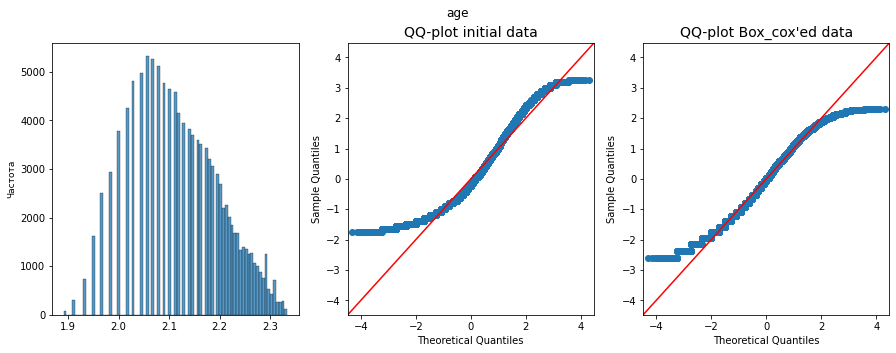

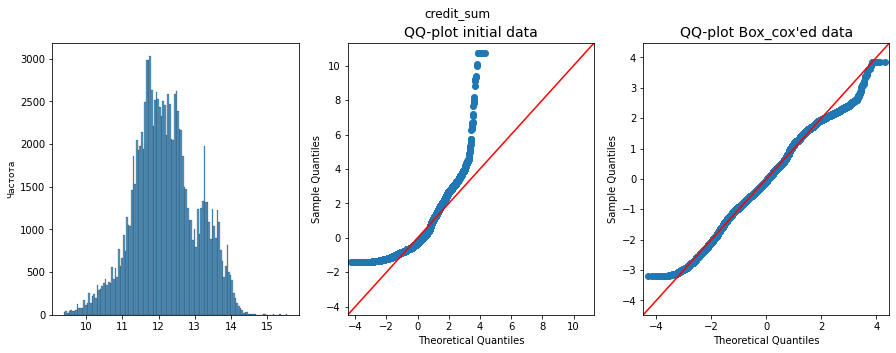

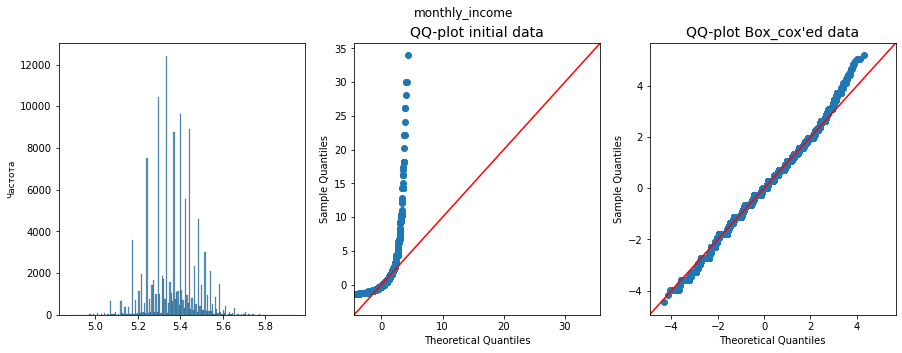

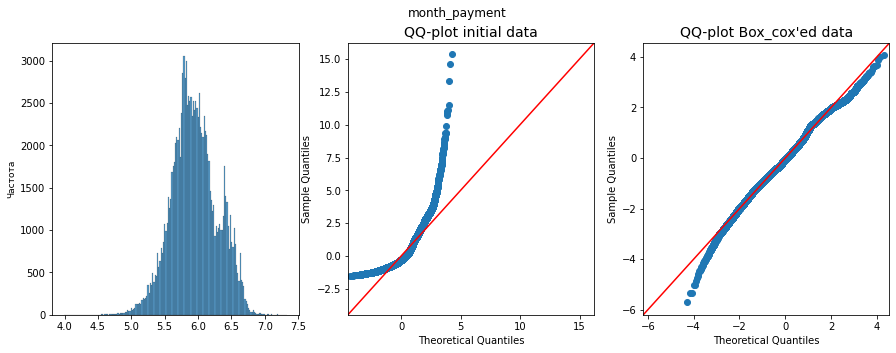

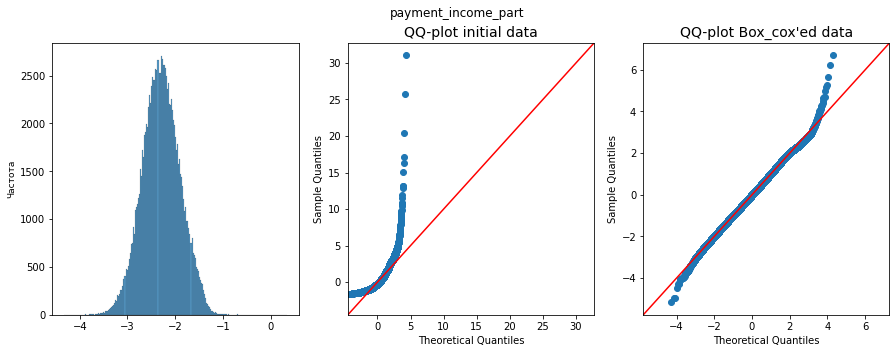

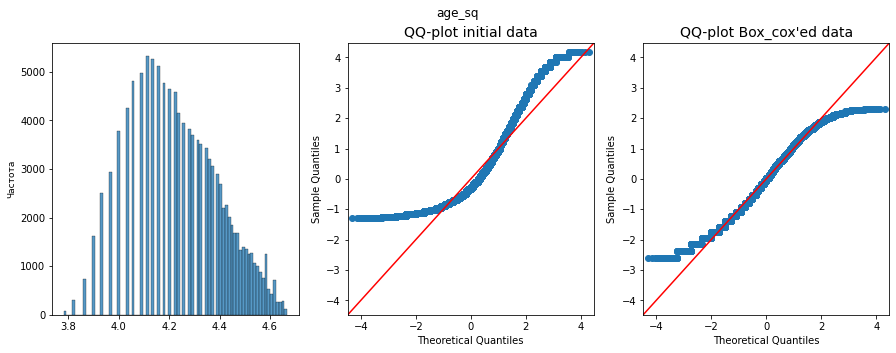

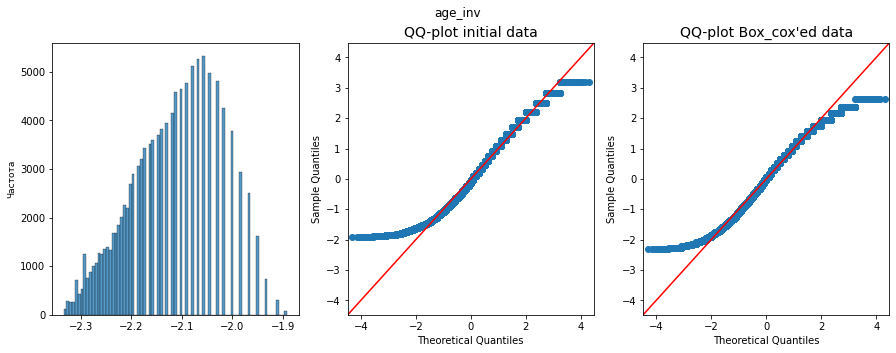

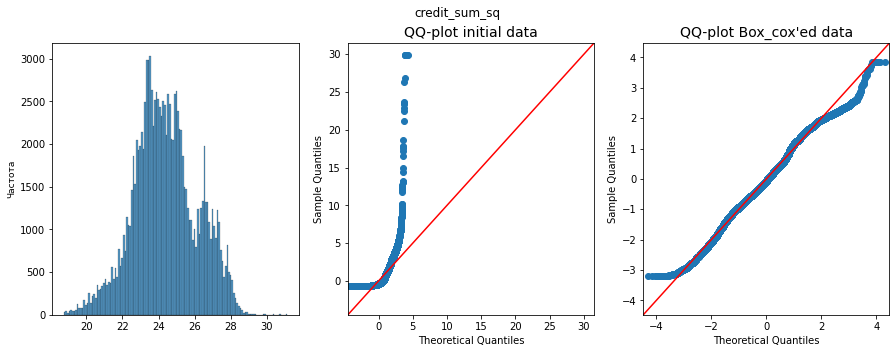

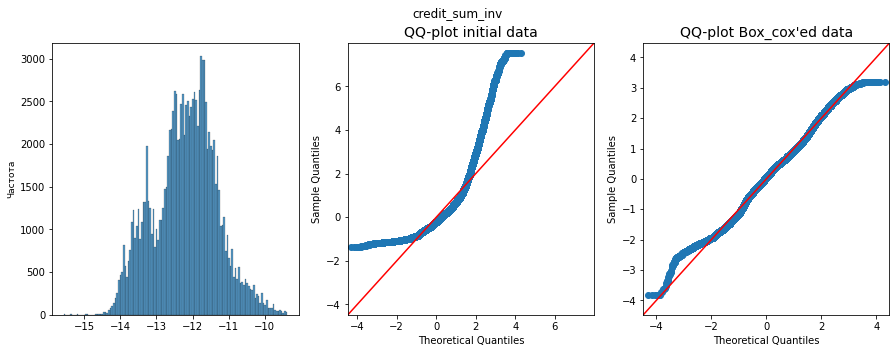

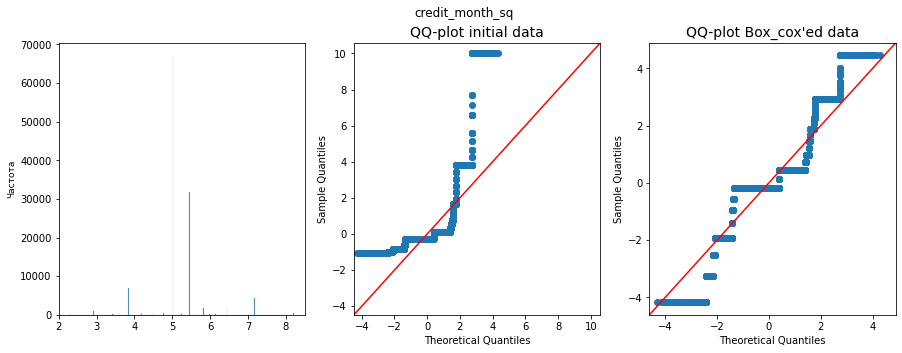

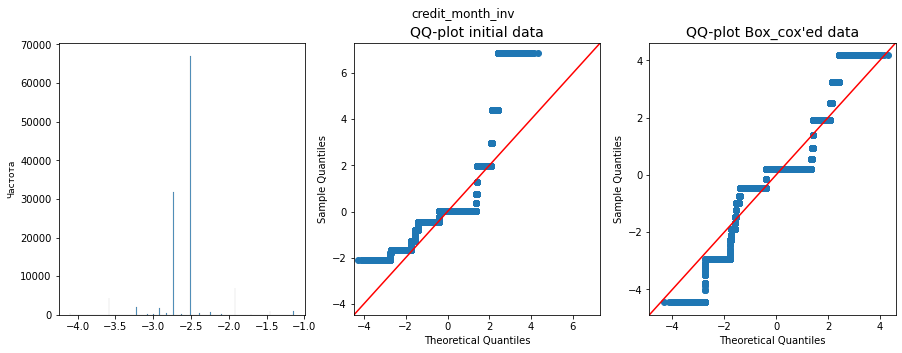

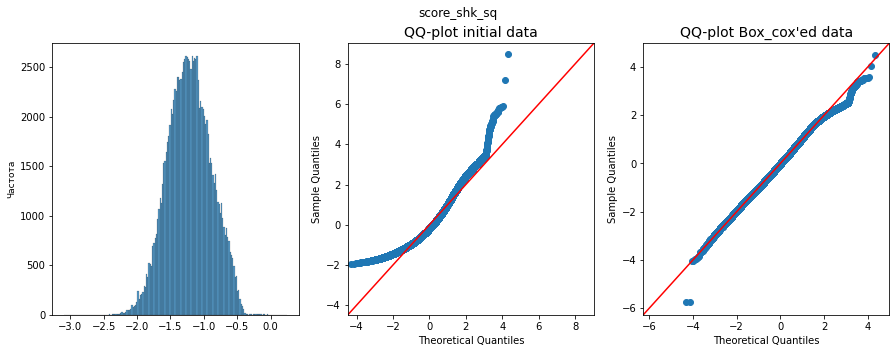

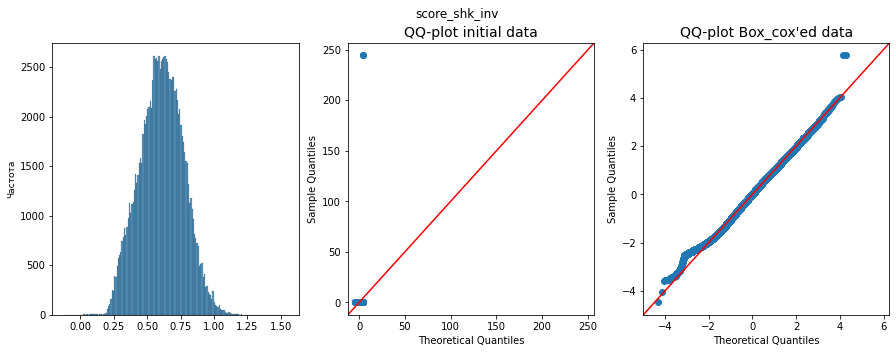

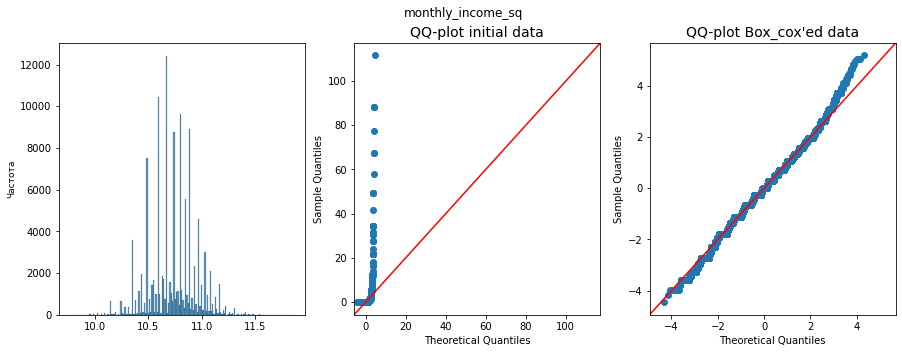

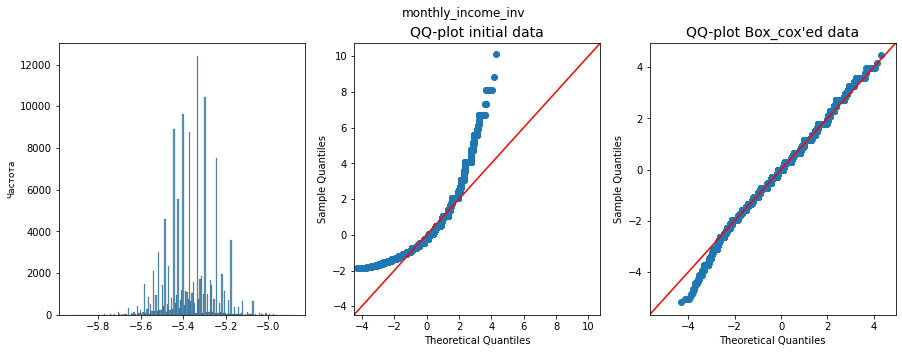

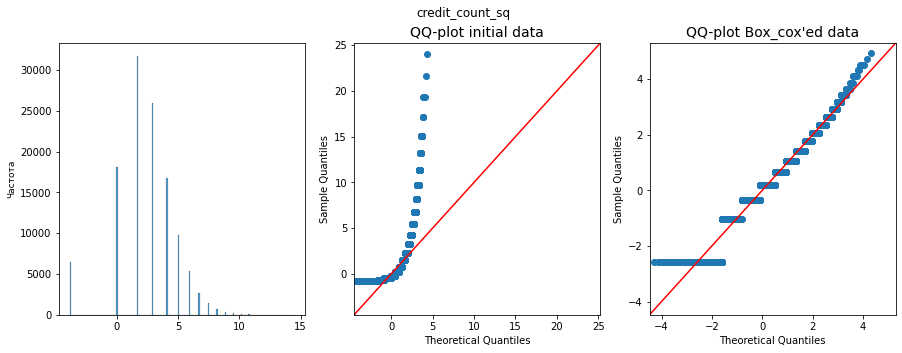

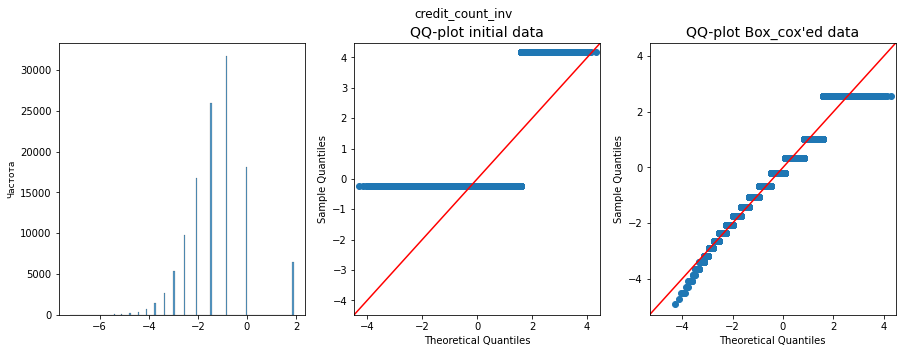

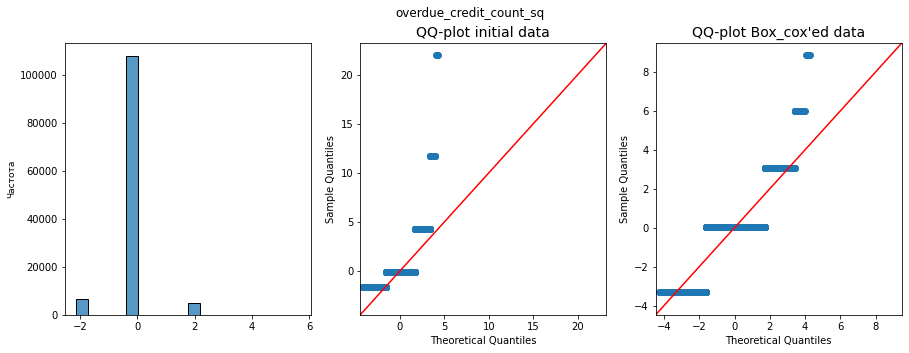

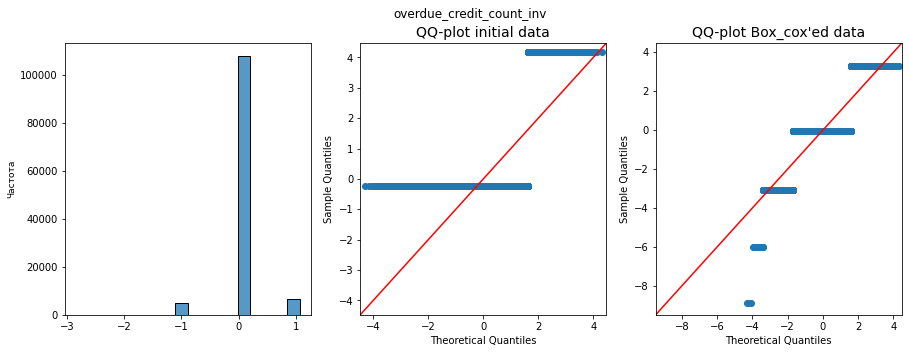

In [88]:
for col in quantitative_cols:
    transformed, lam = boxcox(train[col])
    print(f'Lambda for {col}: {lam:.3f}')

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    sns.histplot(transformed, ax=ax[0])
    qqplot(train[col], norm, fit=True, line='45', ax=ax[1])
    qqplot(transformed, norm, fit=True, line='45', ax=ax[2])

    ax[0].set_ylabel('Частота', fontsize=9)
    ax[1].set_title("QQ-plot initial data", fontsize=14)
    ax[2].set_title("QQ-plot Box_cox'ed data", fontsize=14)
    fig.suptitle(col)

In [89]:
boxcox_cols = ['age','credit_sum',
              'monthly_income', 'month_payment',
              'payment_income_part', 'age_sq',
              'age_inv', 'credit_sum_sq',
              'credit_sum_inv', 'credit_month_sq',
              'credit_month_inv', 'score_shk_sq',
              'score_shk_inv', 'monthly_income_sq',
              'monthly_income_inv', 'credit_count_inv',
              'overdue_credit_count_inv']

In [90]:
transformation_lambdas_wcols = {}
for col in tqdm(boxcox_cols):
    for ind, df in enumerate(datasets):
        df[col] = df[col] + 0.0001
        if ind == 0:
# Поскольку у нас тренировочный датасет первый в списке
            df[col], lam = boxcox(df[col])    
            transformation_lambdas_wcols[col] = lam
        else:
            df[col]= boxcox(df[col], transformation_lambdas_wcols[col])

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  8.85it/s]


In [91]:
cat_cols = train.dtypes[train.dtypes == 'object'].index

In [92]:
train_label = pd.get_dummies(train, columns=cat_cols, drop_first=True)
valid_label = pd.get_dummies(valid, columns=cat_cols, drop_first=True)
test_label = pd.get_dummies(test, columns=cat_cols, drop_first=True)

# Baseline-модель с новыми предикторами

In [93]:
X_train = train_label.drop('open_account_flg', axis=1)
y_train = train_label['open_account_flg']

X_valid = valid_label.drop('open_account_flg', axis=1)
y_valid = valid_label['open_account_flg']

X_test = test_label.drop('open_account_flg', axis=1)
y_test = test_label['open_account_flg']

Также необходимо стандартизовать данные (поскольку у нас не все предикторы имеют нормальное распределение, то лучше воспользоваться классом RobustScaler, который устойчив к выбросам).

In [94]:
scaler = RobustScaler()
scaler.fit(X_train)

X_tr_scaled_wcols = pd.DataFrame(scaler.transform(X_train.values),
                                 columns=X_train.columns,
                                 index=X_train.index)
X_val_scaled_wcols = pd.DataFrame(scaler.transform(X_valid.values),
                                  columns=X_valid.columns,
                                  index=X_valid.index)
X_test_scaled_wcols = pd.DataFrame(scaler.transform(X_test.values),
                                   columns=X_test.columns,
                                   index=X_test.index)

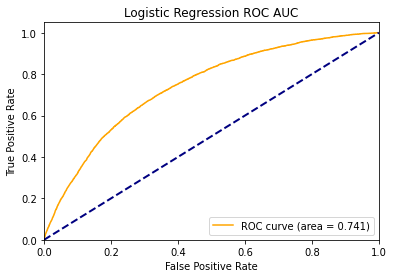

In [95]:
lr_baseline_wcols = make_log_reg(x_train=X_tr_scaled_wcols,
                                 y_train=y_train,
                                 x_valid=X_val_scaled_wcols,
                                 y_valid=y_valid,
                                 results_df=lr_metrics,
                                 model_name='lr_baseline_wcols')

In [96]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

,lr_baseline,lr_baseline_tuned,DummyClassifier,lr_baseline_wcols
roc-auc,0.729256,0.729320,0.500769,0.740714
precision,0.308099,0.308428,0.177318,0.320084
recall,0.646085,0.645754,0.173150,0.657176
f1,0.417232,0.417465,0.175209,0.430492
logloss,10.972707,10.956604,9.910890,10.571155


Видим, что добавление новых предикторов позволило значительно увеличить качество модели. Логистическая регрессия хороша тем, что позволяет достаточно просто интерпретировать вклад каждой переменной на исход (таргетную переменную), однако, для этого необходимо устранить корреляцию между предикторами.

##  Попробуем модель, где отсутствует корреляция между переменными

Вследствие корреляции между предсказателями необходимо проявлять осторожность в интерпертации коэффициентов в множественной регрессии. Мультиколлинеарность может вызвать числовую нестабильность в подгонке уравнения регрессии. Таким образом, для корректной интерпертации коэффициентов регрессии нам необходимо избавиться от коррелированных переменных, что также сократит количество предикторов нашей модели - сделает ее проще, что есть хорошо, согласно бритве Оккама.

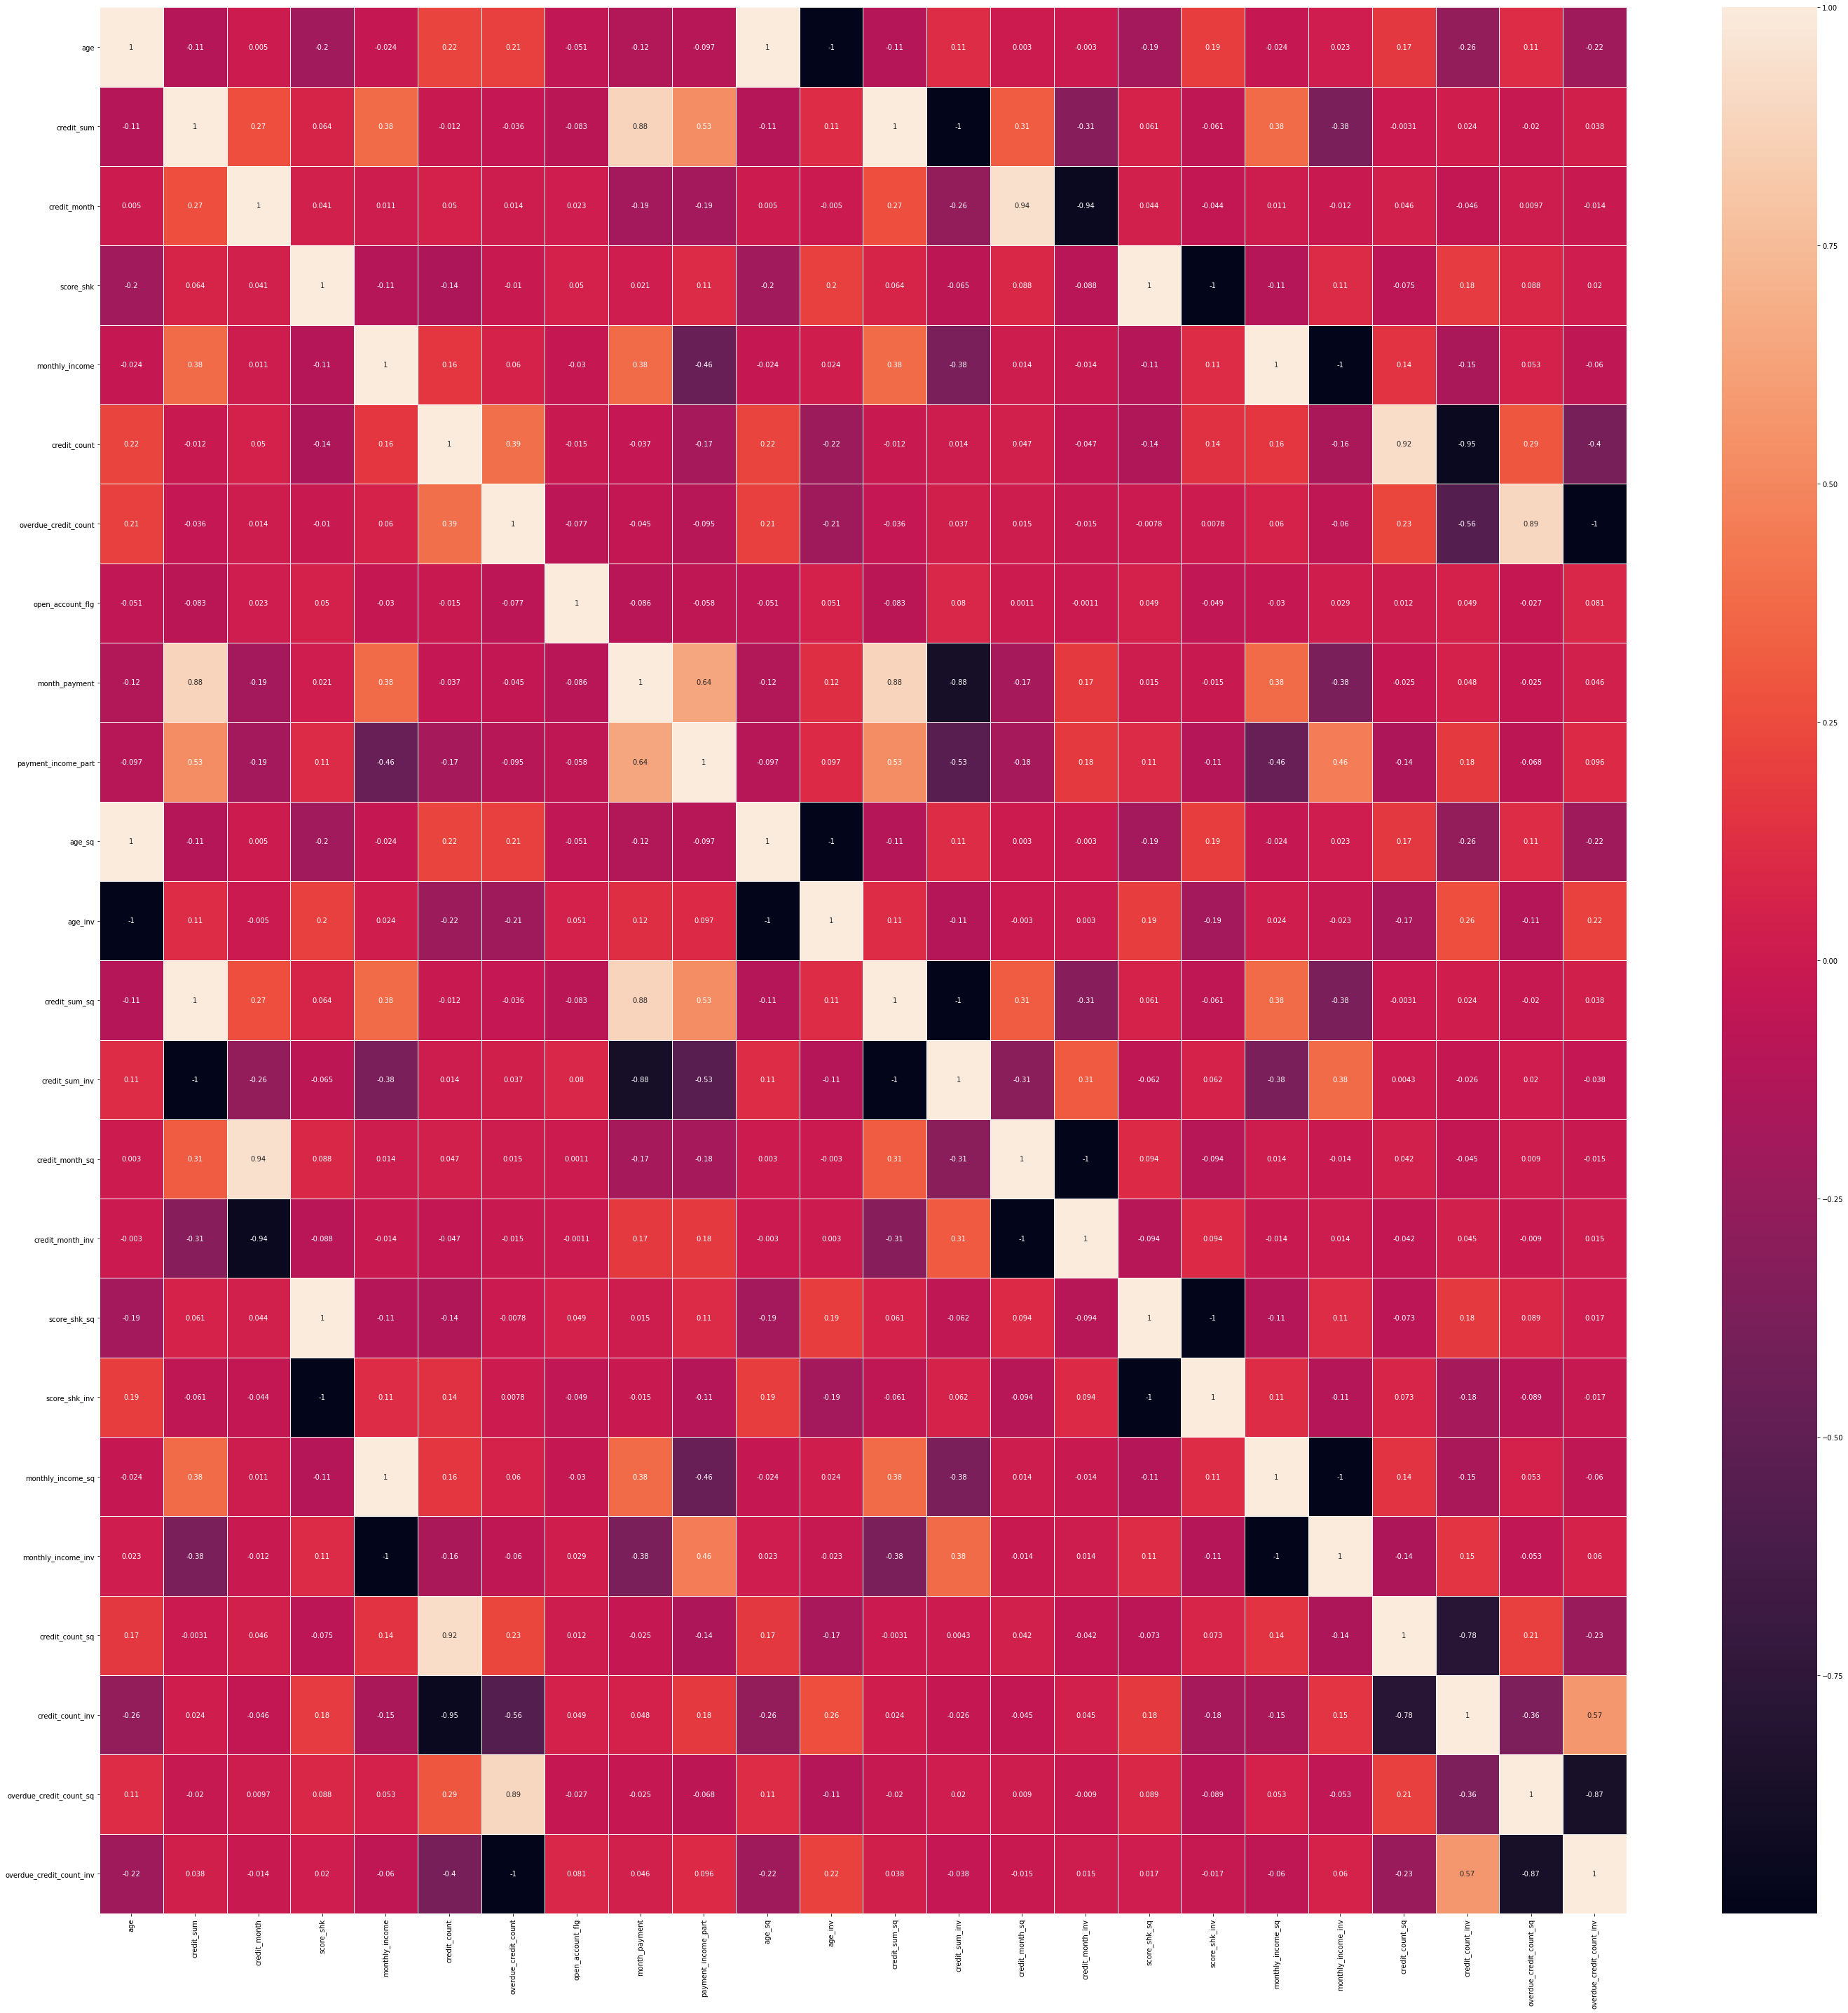

In [87]:
plt.figure(figsize=(40,40))
sns.heatmap(train.corr(method='pearson'), annot=True, linewidths=1)
plt.tight_layout()

Рассмотрим какие переменные имеют какое количество сильных корреляций.

In [98]:
corr_predictors = ((train.corr(method='pearson') > 0.7) |
                   (train.corr(method='pearson') < -0.7)).sum().sort_values(ascending=False)

In [100]:
corr_predictors

credit_sum_sq               4
credit_sum_inv              4
month_payment               4
credit_sum                  4
overdue_credit_count_sq     3
credit_count_inv            3
credit_count_sq             3
monthly_income_inv          3
monthly_income_sq           3
score_shk_inv               3
score_shk_sq                3
credit_month_inv            3
credit_month_sq             3
age                         3
age_inv                     3
age_sq                      3
overdue_credit_count        3
credit_count                3
monthly_income              3
score_shk                   3
credit_month                3
overdue_credit_count_inv    3
payment_income_part         1
open_account_flg            1
dtype: int64

In [113]:
cols_to_drop = corr_predictors[corr_predictors > 3].index
cols_to_drop

Index(['credit_sum_sq', 'credit_sum_inv', 'month_payment', 'credit_sum'], dtype='object')

In [114]:
train_ncorr = train.copy()
valid_ncorr = valid.copy()
test_ncorr = test.copy()    
dfs_ncorr = [train_ncorr, valid_ncorr, test_ncorr]

for df in dfs_ncorr:
    df.drop(cols_to_drop, axis=1, inplace=True)

In [115]:
cat_cols_ncorr = train_ncorr.dtypes[train_ncorr.dtypes == 'object'].index

In [116]:
train_label_ncorr = pd.get_dummies(train_ncorr, columns=cat_cols_ncorr, drop_first=True)
valid_label_ncorr = pd.get_dummies(valid_ncorr, columns=cat_cols_ncorr, drop_first=True)
test_label_ncorr = pd.get_dummies(test_ncorr, columns=cat_cols_ncorr, drop_first=True)

# Baseline-модель с новыми предикторами без корреляции

In [117]:
X_train_ncorr = train_label_ncorr.drop('open_account_flg', axis=1)
y_train_ncorr = train_label_ncorr['open_account_flg']

X_valid_ncorr = valid_label_ncorr.drop('open_account_flg', axis=1)
y_valid_ncorr = valid_label_ncorr['open_account_flg']

X_test_ncorr = test_label_ncorr.drop('open_account_flg', axis=1)
y_test_ncorr = test_label_ncorr['open_account_flg']

Также необходимо стандартизовать данные (поскольку у нас не все предикторы имеют нормальное распределение, то лучше воспользоваться классом RobustScaler, который устойчив к выбросам).

In [118]:
scaler = RobustScaler()
scaler.fit(X_train_ncorr)

X_tr_scaled_ncorr = pd.DataFrame(scaler.transform(X_train_ncorr.values),
                                 columns=X_train_ncorr.columns,
                                 index=X_train_ncorr.index)
X_val_scaled_ncorr = pd.DataFrame(scaler.transform(X_valid_ncorr.values),
                                  columns=X_valid_ncorr.columns,
                                  index=X_valid_ncorr.index)
X_test_scaled_ncorr = pd.DataFrame(scaler.transform(X_test_ncorr.values),
                                   columns=X_test_ncorr.columns,
                                   index=X_test_ncorr.index)

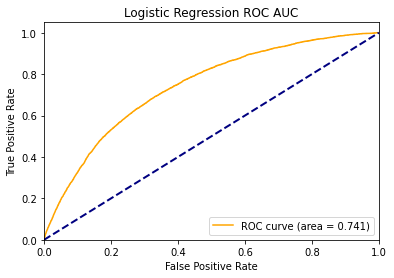

In [119]:
lr_wcols_nocorr = make_log_reg(x_train=X_tr_scaled_ncorr,
                                 y_train=y_train_ncorr,
                                 x_valid=X_val_scaled_ncorr,
                                 y_valid=y_valid_ncorr,
                                 results_df=lr_metrics,
                                 model_name='lr_wcols_nocorr')

In [120]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

,lr_baseline,lr_baseline_tuned,DummyClassifier,lr_baseline_wcols,lr_wcols_nocorr,lr_wcols_nocorr1
roc-auc,0.729256,0.729320,0.500769,0.740714,0.740562,0.740573
precision,0.308099,0.308428,0.177318,0.320084,0.318251,0.318357
recall,0.646085,0.645754,0.173150,0.657176,0.656679,0.656845
f1,0.417232,0.417465,0.175209,0.430492,0.428726,0.428857
logloss,10.972707,10.956604,9.910890,10.571155,10.639590,10.636571


С увеличением числа предикторов, качество модели улучшилось, однако, недообучение модели может вносить свою лепту, поскольку число итераций осталось прежним. Можно проверить зависимость ROC AUC от числа итераций.

In [101]:
iter_num_results = pd.DataFrame(columns=['roc_auc', 'precision_score',
                                         'recall_score', 'f1_score', 'log_loss'])

iter_num_results_funcs = [precision_score, recall_score, f1_score, log_loss]

In [103]:
for iter_num in tqdm(np.linspace(100, 3000, 30)):
    lr_baseline_wcols = LogisticRegression(class_weight = 'balanced',
                                           max_iter=iter_num,
                                           random_state=RND_STATE)
    lr_baseline_wcols.fit(X_tr_scaled, y_train)

    y_pred = lr_baseline_wcols.predict(X_val_scaled)
    y_score = lr_baseline_wcols.predict_proba(X_val_scaled)[:,1]
    
    iter_num_results.at[iter_num, 'roc_auc'] = roc_auc_score(y_valid, y_score)
    
    for i, col in enumerate(iter_num_results.columns[1:]):
        iter_num_results.at[iter_num, col] = iter_num_results_funcs[i](y_valid, y_pred)

  0%|                                                                                           | 0/41 [00:00<?, ?it/s]lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  2%|██                                                                                 | 1/41 [00:02<01:25,  2.14s/it]lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  5%|████   

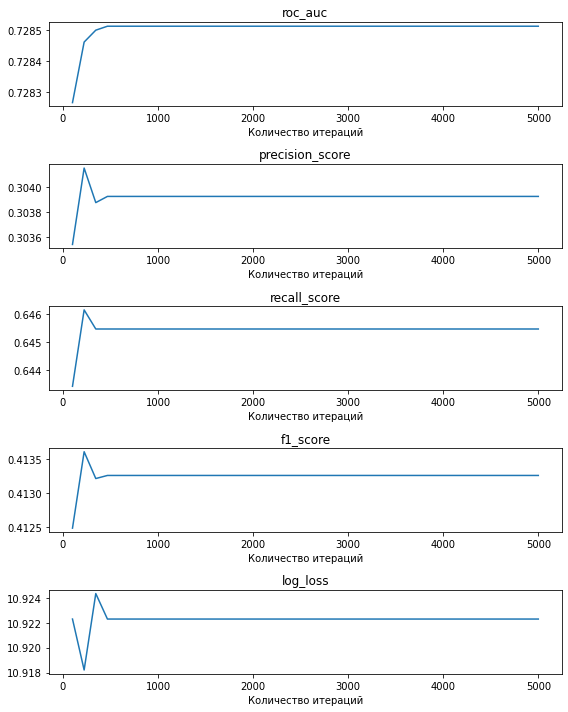

In [104]:
fig, ax = plt.subplots(5,1, figsize=(8,10))
for i, col in enumerate(iter_num_results.columns):
    iter_num_results[col].plot(ax=ax[i])
    ax[i].set_title(col)
    ax[i].set(xlabel='Количество итераций')

fig.tight_layout()

Видно, что при количестве итераций превышающих 1000 улучшение площади под кривой ROC не происходит, следовательно, использование большего количества итераций бессмысленно.

Таким образом, на основании выбранных показателей эффективности, можно заключить, что наилучшая модель - модель, с множеством дополнительных предикторов но без коррелированных переменных. Оптимизируем ее поиском гиперпараметров по сетке.

In [109]:
!telegram-send "grid_cv_wcols_ncorr optimization started!"

In [67]:
%%time
grid_cv_wcols_ncorr = find_optimal_params(x_train=X_tr_scaled_ncorr,
                                          y_train=y_train_ncorr,
                                          parameters_grid=parameters_grid)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


One or more of the test scores are non-finite: [       nan 0.72976362        nan        nan 0.72976362        nan
        nan 0.73091839        nan        nan 0.73094048        nan]
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Наилучший ROC AUC = 0.7309
Наилучшие параметры: {'C': 1000.0, 'l1_ratio': 0.2, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Wall time: 29.6 s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [111]:
!telegram-send "grid_cv_wcols_ncorr optimization is over!"

In [113]:
best_params_wcols_ncorr = grid_cv_wcols_ncorr.best_params_

In [135]:
# best_params_wcols_ncorr = {'C': 500.5, 
#                            'l1_ratio': 0.2,
#                            'max_iter': 4000, 
#                            'penalty': 'l2', 
#                            'solver': 'lbfgs'}

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


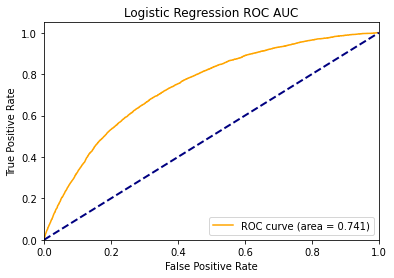

In [136]:
grid_LR_ncorr = make_log_reg(x_train=X_tr_scaled_ncorr,
                                 y_train=y_train_ncorr,
                                 x_valid=X_val_scaled_ncorr,
                                 y_valid=y_valid_ncorr,
                                 results_df=lr_metrics,
                                 parameters=best_params_wcols_ncorr,
                                 model_name='Grid_LR_ncorr')

In [137]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

,lr_baseline,lr_baseline_tuned,DummyClassifier,lr_baseline_wcols,lr_wcols_nocorr,lr_wcols_nocorr1,Grid_LR_ncorr
roc-auc,0.729256,0.729320,0.500769,0.740714,0.740562,0.740573,0.741452
precision,0.308099,0.308428,0.177318,0.320084,0.318251,0.318357,0.318674
recall,0.646085,0.645754,0.173150,0.657176,0.656679,0.656845,0.657341
f1,0.417232,0.417465,0.175209,0.430492,0.428726,0.428857,0.429251
logloss,10.972707,10.956604,9.910890,10.571155,10.639590,10.636571,10.627514


**!!! Выводы по данному этапу !!!**

Далее проведем анализ важности признаков, чтобы отсеять неважные переменные не обладающие предсказательной силой.

# Анализ важности признаков

Важность признаков можно анализировать различными способами, например, в данном проекте будут использованы значения Шепли рассчитанные с использованием библиотеки [shap](https://shap.readthedocs.io/en/latest/api.html), Permutation Importance – это метод оценки важности переменной для предсказательной способности модели. Суть данного подхода заключается в произвольной перестановке или перетасовке одного столбца в наборе датасета (валидации или теста), оставив все остальные столбцы нетронутыми. Признак считается «важным», если точность модели падает и его изменение вызывает увеличение ошибок. С другой стороны, признак считается «неважным», если перетасовка его значений не влияет на точность модели. Для оценки Permutation Importance будут использованы feature_importance_permutation из библиотеки [mlxtend](https://rasbt.github.io/mlxtend/user_guide/evaluate/feature_importance_permutation/) и [sklearn.inspection.permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html).

Для более детального исследования корреляции данных будем использовать [коэффициент инфляции дисперсии](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html) В статистике коэффициент инфляции дисперсии (VIF) - это отношение дисперсии оценки некоторой переменной в модели к дисперсии модели, построенной с использованием только одного члена. Он предоставляет индекс, который измеряет, насколько увеличилась дисперсия (квадрат стандартного отклонения оценки) оценочного коэффициента регрессии из-за коллинеарности.

Наличие сильной корреляционной взаимосвязи между предикторами (на уровне 0,7 и выше) называется мультиколлинеарностью.
Мультиколлинеарность в модели проявляется в следующем:
- сильный разброс оценок коэффициентов регрессии;
- большие положительные и большие отрицательные оценки коэффициентов регрессии, выше 1,0 по модулю.
- резкое изменение оценок коэффициентов регрессии при добавлении или удалении предиктора;
- неправильный знак перед коэффициентом регрессии (например, объем продаж по уравнению регрессии увеличивается при увеличении цены);
- присутствие в модели большого количества статистически незначимых оценок коэффициентов регрессии.

Для устранения мультиколлинеарности можно увеличить размер выборки (не всегда реально), выполнить анализ главных компонент или снизить разброс оценок коэффициентов регрессии с помощью методов регуляризации (упорядочения) регрессии.
Методы регуляризации сокращают вариабельность оценок коэффициентов регрессии путем сжимания оценок до близких к нулю
значений.

In [626]:
x_temp = add_constant(X_tr_scaled_ncorr) #добавляем константу
vif = pd.DataFrame()
vif["features"] = x_temp.columns
vif["VIF Factor"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.shape[1])]

# Значение признака не должно превышать 10, если этого нет, следовательно, признак коррелирован с другим.

divide by zero encountered in double_scalars


In [627]:
vif[vif["VIF Factor"] > 10].features.values

array(['const', 'age', 'credit_month', 'score_shk', 'monthly_income',
       'credit_count', 'overdue_credit_count', 'age_sq', 'age_inv',
       'credit_month_sq', 'credit_month_inv', 'score_shk_sq',
       'score_shk_inv', 'monthly_income_sq', 'monthly_income_inv',
       'credit_count_sq', 'credit_count_inv', 'overdue_credit_count_sq',
       'overdue_credit_count_inv', 'marital_status_MAR',
       'marital_status_UNM', 'job_position_SPC', 'tariff_id_1_1',
       'tariff_id_1_6', 'education_GRD', 'education_SCH', 'education_UGR',
       'living_region_АРХАНГЕЛЬСКАЯ', 'living_region_АСТРАХАНСКАЯ',
       'living_region_БАШКОРТОСТАН', 'living_region_БУРЯТИЯ',
       'living_region_ВЛАДИМИРСКАЯ', 'living_region_ВОЛГОГРАДСКАЯ',
       'living_region_ВОЛОГОДСКАЯ', 'living_region_ВОРОНЕЖСКАЯ',
       'living_region_ЗАБАЙКАЛЬСКИЙ', 'living_region_ИВАНОВСКАЯ',
       'living_region_ИРКУТСКАЯ', 'living_region_КАЛУЖСКАЯ',
       'living_region_КЕМЕРОВСКАЯ', 'living_region_КОМИ',
       'living

На основании полученных результатов можно заключить, что у нас все еще имеются коррелированные столбцы, помимо полученных при кодировании категориальных переменных.

Посмотрим на перутированные важности предикторов с помощью функции feature_importance_permutation библиотеки mlxtend.

In [647]:
from mlxtend.evaluate import feature_importance_permutation
 
imp_vals, _ = feature_importance_permutation(
                predict_method=tuned_lr_ncorr.predict,
                X = X_tr_scaled_ncorr.values,
                y = y_train_ncorr.values,
                metric='accuracy',
                num_rounds=50,
                seed=RND_STATE)

In [648]:
!telegram-send "feature_importance_permutation ready!"

In [649]:
feat_imp = pd.DataFrame(index=X_tr_scaled_ncorr.columns,
                        data=imp_vals, columns=['Feature importance'])

<AxesSubplot:>

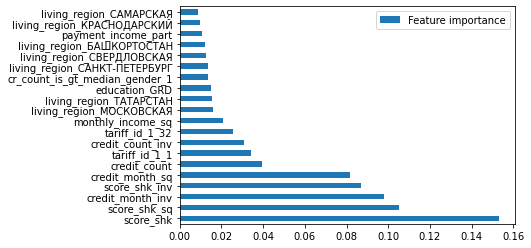

In [650]:
feat_imp.sort_values('Feature importance', ascending=False)[:20].plot(kind='barh')

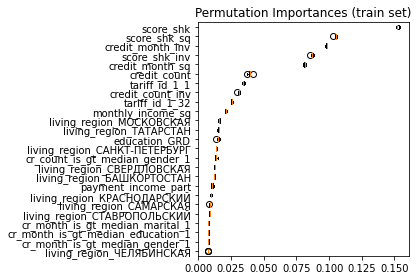

In [652]:
perm_imp_train = permutation_importance(tuned_lr_ncorr,
                                        X_tr_scaled_ncorr,
                                        y_train_ncorr,
                                        n_repeats=10,
                                        random_state=RND_STATE)

sorted_idx = perm_imp_train.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_train.importances[sorted_idx][-25:].T, vert=False,
    labels=X_tr_scaled_ncorr.columns[sorted_idx][-25:]
)

ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

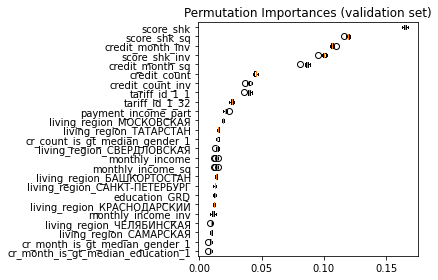

In [653]:
perm_imp_test = permutation_importance(tuned_lr_ncorr,
                                       X_val_scaled_ncorr,
                                       y_valid_ncorr,
                                       n_repeats=10,
                                       random_state=RND_STATE)

sorted_idx = perm_imp_test.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_test.importances[sorted_idx][-25:].T, vert=False,
    labels=X_val_scaled_ncorr.columns[sorted_idx][-25:]
)

ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

In [ ]:
!telegram-send "permutation_importance ready!"

Ввиду мультиколлинеарности мы не можем достоверно определить важность каждого предиктора в модели. Нам необходимо провести очистку переменных от их коррелированных собратьев. Можно попробовать построить дендрограмму коррелированных переменных и выбрать из полученного кластера один предиктор.

In [138]:
quant_cols = ['age', 'credit_sum', 'credit_month', 'score_shk', 'monthly_income',
              'credit_count', 'overdue_credit_count','month_payment',
              'payment_income_part', 'age_sq', 'age_inv',
              'credit_sum_sq', 'credit_sum_inv', 'credit_month_sq',
              'credit_month_inv', 'score_shk_sq', 'score_shk_inv',
              'monthly_income_sq', 'monthly_income_inv', 'credit_count_sq',
              'credit_count_inv', 'overdue_credit_count_sq',
              'overdue_credit_count_inv']

In [165]:
def find_corr_features(df, quant_cols):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    corr = spearmanr(df[quant_cols]).correlation

    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    # We convert the correlation matrix to a distance matrix before performing
    # hierarchical clustering using Ward's linkage.
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = ward(squareform(distance_matrix))
    dendro = dendrogram(dist_linkage,
                        labels=df[quant_cols].columns.tolist(),
                        ax=ax1, leaf_rotation=90)

    dendro_idx = np.arange(0, len(dendro["ivl"]))

    ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
    ax2.set_xticks(dendro_idx)
    ax2.set_yticks(dendro_idx)
    ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
    ax2.set_yticklabels(dendro["ivl"])
    fig.tight_layout()
    plt.show()
    
    predictors_clusters = pd.DataFrame(index=dendro["ivl"])
    cluster_ids = fcluster(dist_linkage, 0, criterion="distance")
    predictors_clusters['Clusters'] = cluster_ids
    
    return predictors_clusters.sort_values('Clusters')

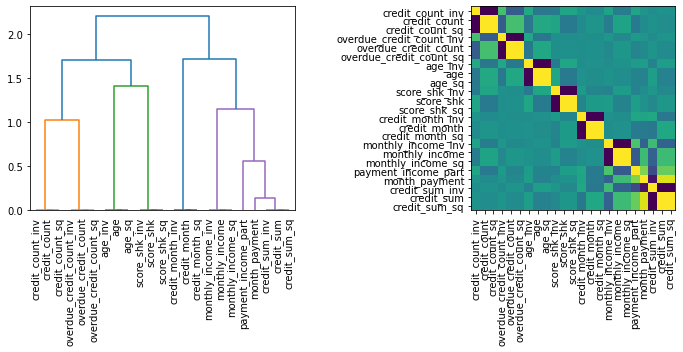

,Clusters
credit_sum_inv,1
month_payment,1
overdue_credit_count_sq,1
credit_sum_sq,2
credit_sum,2
age_inv,2
score_shk,3
score_shk_inv,3
credit_count_inv,3
overdue_credit_count_inv,4


In [166]:
find_corr_features(X_tr_scaled_wcols, quant_cols)

Можно выбирать предикторы автоматически, однако, более целесообразно отбирать те,
которые не были созданы нами самостоятельно, чтобы в дальнейшем сделать pipeline 
попроще.

In [184]:
selected_features = [
    'month_payment', 'credit_sum', 'monthly_income',
    'age', 'credit_month', 'overdue_credit_count',
    'credit_count', 'score_shk', 'score_shk_sq'
]

In [185]:
cols_to_drop_dend = list(set(quant_cols) - set(selected_features))

In [186]:
cols_to_drop_dend 

['credit_sum_sq',
 'monthly_income_inv',
 'age_sq',
 'overdue_credit_count_sq',
 'credit_month_inv',
 'score_shk_inv',
 'credit_count_sq',
 'credit_month_sq',
 'monthly_income_sq',
 'credit_count_inv',
 'credit_sum_inv',
 'overdue_credit_count_inv',
 'age_inv',
 'payment_income_part']

In [187]:
X_tr_scaled_wcols_denddrop = X_tr_scaled_wcols.drop(cols_to_drop_dend, axis=1)
X_val_scaled_wcols_denddrop = X_val_scaled_wcols.drop(cols_to_drop_dend, axis=1)
X_test_scaled_wcols_denddrop = X_test_scaled_wcols.drop(cols_to_drop_dend, axis=1)

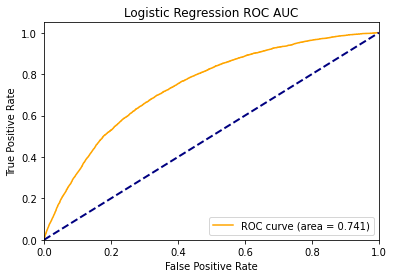

In [188]:
lr_denddrop = make_log_reg(x_train=X_tr_scaled_wcols_denddrop,
                                 y_train=y_train_ncorr,
                                 x_valid=X_val_scaled_wcols_denddrop,
                                 y_valid=y_valid_ncorr,
                                 results_df=lr_metrics,
                                 model_name='lr_denddrop')

In [189]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

,lr_baseline,lr_baseline_tuned,DummyClassifier,lr_baseline_wcols,lr_wcols_nocorr,lr_wcols_nocorr1,Grid_LR_ncorr,lr_denddrop
roc-auc,0.729256,0.729320,0.500769,0.740714,0.740562,0.740573,0.741452,0.740597
precision,0.308099,0.308428,0.177318,0.320084,0.318251,0.318357,0.318674,0.319704
recall,0.646085,0.645754,0.173150,0.657176,0.656679,0.656845,0.657341,0.658831
f1,0.417232,0.417465,0.175209,0.430492,0.428726,0.428857,0.429251,0.430503
logloss,10.972707,10.956604,9.910890,10.571155,10.639590,10.636571,10.627514,10.597322


Проверим важность признаков после удаления коррелированных столбцов.

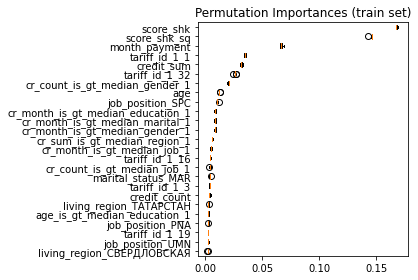

In [664]:
perm_imp_train = permutation_importance(lr_denddrop,
                                        X_tr_scaled_wcols_denddrop,
                                        y_train,
                                        n_repeats=10,
                                        random_state=RND_STATE)

sorted_idx = perm_imp_train.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_train.importances[sorted_idx][-25:].T, vert=False,
    labels=X_tr_scaled_wcols_denddrop.columns[sorted_idx][-25:]
)

ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

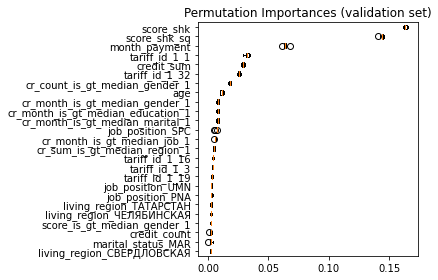

In [665]:
perm_imp_test = permutation_importance(lr_denddrop,
                                       X_val_scaled_wcols_denddrop,
                                       y_valid,
                                       n_repeats=10,
                                       random_state=RND_STATE)

sorted_idx = perm_imp_test.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_test.importances[sorted_idx][-25:].T, vert=False,
    labels=X_val_scaled_wcols_denddrop.columns[sorted_idx][-25:]
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

Видим, что важность параметров модели изменилась, посмотрим на значения Шепли для них.

In [190]:
explainer = shap.LinearExplainer(lr_denddrop,
                                 X_tr_scaled_wcols_denddrop,
                                 feature_perturbation="interventional")

shap_values = explainer(X_val_scaled_wcols_denddrop)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


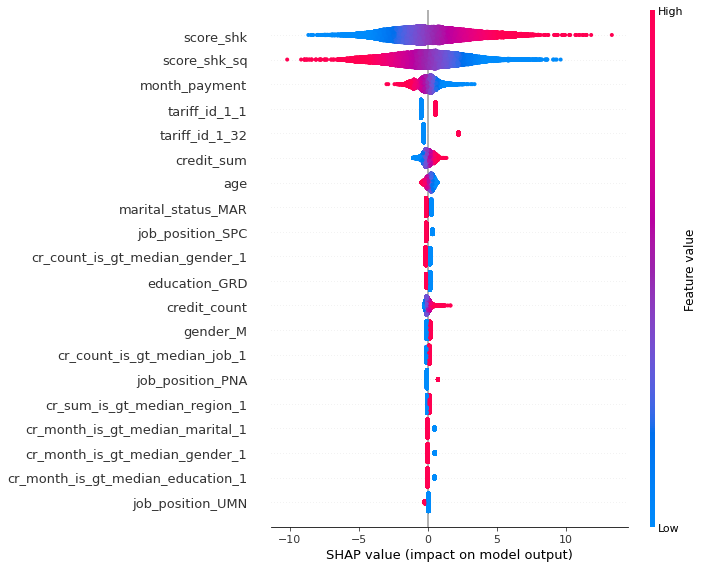

In [191]:
shap.summary_plot(shap_values, X_val_scaled_wcols_denddrop)

In [668]:
# explainer = shap.LinearExplainer(tuned_lr_gr_wcols_denddrop,
#                                  X_tr_scaled_wcols_denddrop,
#                                  feature_perturbation="correlation_dependent")
# shap_values = explainer(X_val_scaled_wcols_denddrop)

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

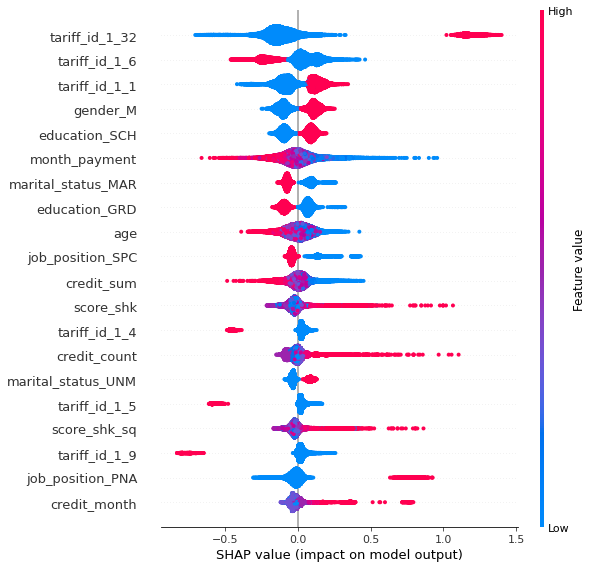

In [669]:
# shap.summary_plot(shap_values, X_val_scaled_wcols_denddrop)

**Можно заметить, что на данном этапе наибольшую предиктивную способность носят тарифы 1-32, 1-1; людям, которым были предложены данные тарифы, имели большую конверсию. Также внутренняя скоринговая оценка вносит наибольшую разрешающую способность, люди с высокой оценкой более склонны открывать счет в банке Тинькофф. Высокий ежемесячный платеж, напротив, отпугивает клиентов.**

**Далее обучим модель с большей силой регуляризации, что позволит обнулить некоторые коэффициенты регрессии и, соответственно, откинуть те, которые вносят только шум.**

In [192]:
parameters_grid_C_lt1 = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.2, 0.4, 0.6, 0.8, 1.],
    'solver': ['sag', 'liblinear', 'lbfgs'],
    'l1_ratio': [0.2, 0.4, 0.6, 0.8],
    'max_iter': np.arange(500, 1200, 100)
}

In [220]:
!telegram-send "_C_lt1 grid optimization started!"

In [ ]:
%%time
grid_cv_wcols_C_lt1 = find_optimal_params(x_train=X_tr_scaled_wcols_denddrop,
                                          y_train=y_train,
                                          parameters_grid=parameters_grid_C_lt1)

In [222]:
!telegram-send "_C_lt1 grid optimization is over!"

In [224]:
best_params_wcols_C_lt1 = grid_cv_wcols_C_lt1.best_params_

In [193]:
# best_params_wcols_C_lt1 = {
#     'C': 1.0,
#     'l1_ratio': 0.2,
#     'max_iter': 600,
#     'penalty': 'l2',
#     'solver': 'lbfgs'
# }

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


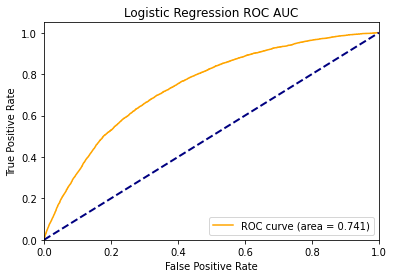

In [194]:
tuned_lr_gr_wcols_C_lt1 = make_log_reg(x_train=X_tr_scaled_wcols_denddrop,
                                       y_train=y_train,
                                       x_valid=X_val_scaled_wcols_denddrop,
                                       y_valid=y_valid,
                                       results_df=lr_metrics,
                                       parameters=best_params_wcols_C_lt1,
                                       model_name='lr_tuned_denddrop_C_lt1')

In [195]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

,lr_baseline,lr_baseline_tuned,DummyClassifier,lr_baseline_wcols,lr_wcols_nocorr,lr_wcols_nocorr1,Grid_LR_ncorr,lr_denddrop,lr_tuned_denddrop_C_lt1
roc-auc,0.729256,0.729320,0.500769,0.740714,0.740562,0.740573,0.741452,0.740597,0.740597
precision,0.308099,0.308428,0.177318,0.320084,0.318251,0.318357,0.318674,0.319704,0.319704
recall,0.646085,0.645754,0.173150,0.657176,0.656679,0.656845,0.657341,0.658831,0.658831
f1,0.417232,0.417465,0.175209,0.430492,0.428726,0.428857,0.429251,0.430503,0.430503
logloss,10.972707,10.956604,9.910890,10.571155,10.639590,10.636571,10.627514,10.597322,10.597322


### Отсев переменных не обладающих предсказательной способностью

Далее мы проведем отсев сконструированных переменных на основании значения их коэффициентов в уравнении регресии.

In [196]:
tuned_lr_gr_wcols_C_lt1_coef = pd.DataFrame(
    index=['intercept'] + X_tr_scaled_wcols_denddrop.columns.to_list(),
    data=[tuned_lr_gr_wcols_C_lt1.intercept_[0]] + tuned_lr_gr_wcols_C_lt1.coef_[0].tolist(),
    columns=['coef']).sort_values('coef', ascending=False)

In [211]:
indices_to_drop = tuned_lr_gr_wcols_C_lt1_coef.query('-0.1 < coef < 0.1').index
indices_to_drop = indices_to_drop[indices_to_drop.str.contains('_is_gt_')]

24

In [220]:
tuned_lr_gr_wcols_C_lt1_coef.iloc[:,[-1]].query('-0.1 < coef < 0.1').index

Index(['education_PGR', 'age_is_gt_median_education_1', 'living_region_АДЫГЕЯ',
       'cr_sum_is_gt_median_education_1', 'tariff_id_1_4', 'education_SCH',
       'score_is_gt_median_job_1', 'monthly_income',
       'living_region_СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ', 'age_is_gt_median_marital_1',
       'score_is_gt_median_marital_1', 'cr_month_is_gt_median_region_1',
       'cr_sum_is_gt_median_gender_1', 'job_position_PNI', 'tariff_id_1_6',
       'age_is_gt_median_region_1', 'score_is_gt_median_education_1',
       'cr_count_is_gt_median_marital_1', 'marital_status_WID',
       'cr_count_is_gt_median_education_1', 'income_is_gt_median_job_1',
       'age_is_gt_median_gender_1', 'credit_month', 'living_region_ЕВРЕЙСКАЯ',
       'cr_sum_is_gt_median_job_1', 'score_is_gt_median_region_1',
       'income_is_gt_median_marital_1', 'income_is_gt_median_gender_1',
       'cr_count_is_gt_median_region_1', 'living_region_ЯМАЛО-НЕНЕЦКИЙ',
       'income_is_gt_median_education_1', 'cr_sum_is_gt_median_marit

In [241]:
def filter_coefs(X_train, X_valid, coef_df, results_df, threshold, params):
    indices_to_drop = coef_df.iloc[:,[-1]].query('-@threshold < coef < @threshold').index
    indices_to_drop = indices_to_drop[indices_to_drop.str.contains('_is_gt_')]
    step = 0
    
    while indices_to_drop.shape[0] != 0:
        X_train = X_train.drop(indices_to_drop, axis=1)
        X_valid = X_valid.drop(indices_to_drop, axis=1)
        print(f'Шаг номер: {step}')
        print(f'Были выброшены: {indices_to_drop}')
        print('-' * 25)
        
        log_reg = make_log_reg(x_train=X_train,
                               y_train=y_train,
                               x_valid=X_valid,
                               y_valid=y_valid,
                               results_df=results_df,
                               parameters=params,
                               model_name='filter_coefs_' + str(step))
        
        coefs = pd.DataFrame(
            index=['intercept'] + X_valid.columns.to_list(),
            data=[log_reg.intercept_[0]] + log_reg.coef_[0].tolist(),
            columns=['coef_step_' + str(step)])
        
        coef_df = coef_df.merge(coefs, how='left', left_index=True, right_index=True)
        
        query_str = f'-@threshold < coef_step_{step} < @threshold'
        indices_to_drop = coef_df.query(query_str).index
        indices_to_drop = indices_to_drop[indices_to_drop.str.contains('_is_gt_')]
        step += 1
        
    return coef_df

Шаг номер: 0
Были выброшены: Index(['age_is_gt_median_education_1', 'cr_sum_is_gt_median_education_1',
       'score_is_gt_median_job_1', 'age_is_gt_median_marital_1',
       'score_is_gt_median_marital_1', 'cr_month_is_gt_median_region_1',
       'cr_sum_is_gt_median_gender_1', 'age_is_gt_median_region_1',
       'score_is_gt_median_education_1', 'cr_count_is_gt_median_marital_1',
       'cr_count_is_gt_median_education_1', 'income_is_gt_median_job_1',
       'age_is_gt_median_gender_1', 'cr_sum_is_gt_median_job_1',
       'score_is_gt_median_region_1', 'income_is_gt_median_marital_1',
       'income_is_gt_median_gender_1', 'cr_count_is_gt_median_region_1',
       'income_is_gt_median_education_1', 'cr_sum_is_gt_median_marital_1',
       'income_is_gt_median_region_1', 'cr_month_is_gt_median_job_1',
       'age_is_gt_median_job_1', 'score_is_gt_median_gender_1'],
      dtype='object')
-------------------------


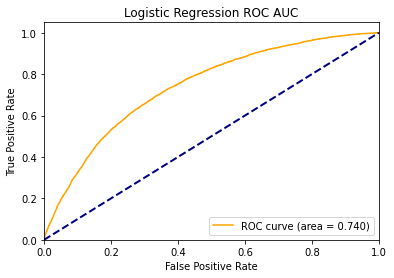

Шаг номер: 1
Были выброшены: Index(['overdue_count_is_gt_median_education_1',
       'overdue_count_is_gt_median_region_1',
       'overdue_count_is_gt_median_job_1',
       'overdue_count_is_gt_median_marital_1',
       'overdue_count_is_gt_median_gender_1'],
      dtype='object')
-------------------------


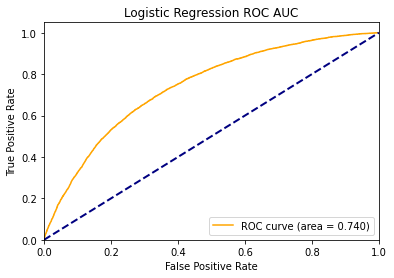

,lr_baseline,lr_baseline_tuned,DummyClassifier,lr_baseline_wcols,lr_wcols_nocorr,lr_wcols_nocorr1,Grid_LR_ncorr,lr_denddrop,lr_tuned_denddrop_C_lt1,filter_coefs_0,filter_coefs_1
roc-auc,0.729256,0.729320,0.500769,0.740714,0.740562,0.740573,0.741452,0.740597,0.740597,0.739981,0.739984
precision,0.308099,0.308428,0.177318,0.320084,0.318251,0.318357,0.318674,0.319704,0.319704,0.318646,0.318646
recall,0.646085,0.645754,0.173150,0.657176,0.656679,0.656845,0.657341,0.658831,0.658831,0.656017,0.656017
f1,0.417232,0.417465,0.175209,0.430492,0.428726,0.428857,0.429251,0.430503,0.430503,0.428943,0.428943
logloss,10.972707,10.956604,9.910890,10.571155,10.639590,10.636571,10.627514,10.597322,10.597322,10.619462,10.619462


In [244]:
params = {
    'penalty':'l1',
    'C':0.2,
    'solver':'liblinear'
}

coef_df = filter_coefs(X_tr_scaled_wcols_denddrop,
             X_val_scaled_wcols_denddrop,
             tuned_lr_gr_wcols_C_lt1_coef,
             lr_metrics, 0.1, params)

lr_metrics.style.highlight_max(axis=1, color='lightblue')

In [237]:
coef_df.query('-0.15 < coef_step_0 < 0.15').index

Index(['living_region_АЛТАЙ', 'living_region_КАЛМЫКИЯ', 'living_region_МОСКВА',
       'education_PGR', 'living_region_АДЫГЕЯ', 'tariff_id_1_4',
       'education_SCH', 'monthly_income',
       'living_region_СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ', 'job_position_PNI',
       'tariff_id_1_6', 'marital_status_WID', 'credit_month',
       'living_region_ЕВРЕЙСКАЯ', 'living_region_ЯМАЛО-НЕНЕЦКИЙ',
       'job_position_WRP', 'job_position_WOI', 'living_region_ТОМСКАЯ',
       'tariff_id_1_22', 'tariff_id_1_5', 'marital_status_DIV',
       'marital_status_UNM', 'living_region_ЗАБАЙКАЛЬСКИЙ',
       'living_region_САХА/ЯКУТИЯ/', 'living_region_КАМЧАТСКИЙ'],
      dtype='object')

In [690]:
cols_to_drop_2 = ['score_is_gt_median_job_1', 'cr_month_is_gt_median_region_1',
                  'cr_count_is_gt_median_education_1', 'cr_sum_is_gt_median_education_1',
                  'monthly_income', 'age_is_gt_median_marital_1',
                  'score_is_gt_median_education_1', 'score_is_gt_median_region_1',
                  'cr_sum_is_gt_median_gender_1', 'age_is_gt_median_gender_1',
                  'cr_count_is_gt_median_marital_1', 'cr_sum_is_gt_median_job_1',
                  'income_is_gt_median_job_1', 'credit_month',
                  'score_is_gt_median_marital_1', 'cr_count_is_gt_median_region_1',
                  'income_is_gt_median_marital_1', 'age_is_gt_median_region_1', 
                  'income_is_gt_median_education_1', 'income_is_gt_median_gender_1',
                  'age_is_gt_median_job_1', 'income_is_gt_median_region_1',
                  'cr_sum_is_gt_median_marital_1']

При рассмотрении коэффициентов регрессии было замечено, что `credit_month` и `monthly_income` не имеют предсказательной силы, что вероятнее всего связано с сконструированной переменной `month_payment`. 

In [691]:
X_tr_scaled_wcols_drop_2 = X_tr_scaled_wcols_denddrop.drop(cols_to_drop_2, axis=1)
X_val_scaled_wcols_drop_2 = X_val_scaled_wcols_denddrop.drop(cols_to_drop_2, axis=1)
X_test_scaled_wcols_drop_2 = X_test_scaled_wcols_denddrop.drop(cols_to_drop_2, axis=1)

In [701]:
tuned_lr_gr_wcols_drop_2 = LogisticRegression(class_weight='balanced',
                                              random_state=RND_STATE,
                                              max_iter=700)

tuned_lr_gr_wcols_drop_2.fit(X_tr_scaled_wcols_drop_2, y_train)

y_pred_wcols_drop_2 = tuned_lr_gr_wcols_drop_2.predict(X_val_scaled_wcols_drop_2)
y_score_wcols_drop_2 = tuned_lr_gr_wcols_drop_2.predict_proba(X_val_scaled_wcols_drop_2)[:,1]

In [702]:
lr_metrics['lr_denddrop_2'] = [roc_auc_score(y_valid, y_score_wcols_drop_2),
                              precision_score(y_valid, y_pred_wcols_drop_2),
                              recall_score(y_valid, y_pred_wcols_drop_2),
                              f1_score(y_valid, y_pred_wcols_drop_2),
                              log_loss(y_valid, y_pred_wcols_drop_2)]

In [238]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

,lr_baseline,lr_baseline_tuned,DummyClassifier,lr_baseline_wcols,lr_wcols_nocorr,lr_wcols_nocorr1,Grid_LR_ncorr,lr_denddrop,lr_tuned_denddrop_C_lt1,filter_coefs_0
roc-auc,0.729256,0.729320,0.500769,0.740714,0.740562,0.740573,0.741452,0.740597,0.740597,0.740157
precision,0.308099,0.308428,0.177318,0.320084,0.318251,0.318357,0.318674,0.319704,0.319704,0.318725
recall,0.646085,0.645754,0.173150,0.657176,0.656679,0.656845,0.657341,0.658831,0.658831,0.657341
f1,0.417232,0.417465,0.175209,0.430492,0.428726,0.428857,0.429251,0.430503,0.430503,0.429297
logloss,10.972707,10.956604,9.910890,10.571155,10.639590,10.636571,10.627514,10.597322,10.597322,10.625501


In [695]:
explainer = shap.LinearExplainer(tuned_lr_gr_wcols_drop_2,
                                 X_tr_scaled_wcols_drop_2,
                                 feature_perturbation="interventional")
shap_values = explainer(X_val_scaled_wcols_drop_2)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


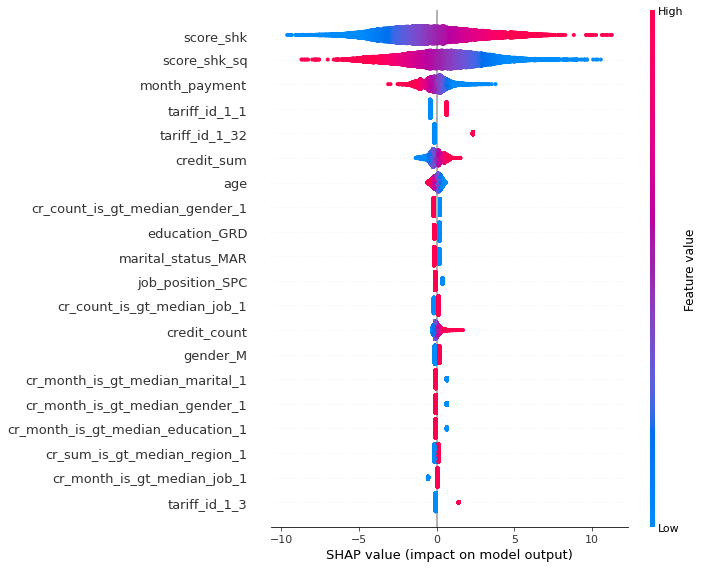

In [696]:
shap.summary_plot(shap_values, X_val_scaled_wcols_drop_2)

In [783]:
# tuned_lr_gr_wcols_C_lt1_coef['coef_drop'] = tuned_lr_gr_wcols_drop_2.coef_[0]
coef_tuned_lr_gr_wcols_drop_2 = pd.DataFrame(
    index=['intercept'] + X_val_scaled_wcols_drop_2.columns.to_list(),
    data=[tuned_lr_gr_wcols_drop_2.intercept_[0]] + tuned_lr_gr_wcols_drop_2.coef_[0].tolist(),
    columns=['coef_drop']).sort_values('coef_drop', ascending=False)

In [784]:
diff_cols_coef = tuned_lr_gr_wcols_C_lt1_coef.merge(coef_tuned_lr_gr_wcols_drop_2, how='left',
                                   left_index=True, right_index=True)

In [785]:
diff_cols_coef

,coef,coef_drop
score_shk,3.995040,4.022854
tariff_id_1_99,2.569717,2.573047
tariff_id_1_32,2.488013,2.489112
tariff_id_1_91,1.895905,1.909914
tariff_id_1_25,1.872158,1.918382
...,...,...
living_region_ТАМБОВСКАЯ,-0.867378,-0.886862
intercept,-0.880010,-0.955971
living_region_ВОЛОГОДСКАЯ,-0.923705,-0.942792
score_shk_sq,-3.557948,-3.554418


Для максимального обнуления коэффициентов регрессии можно применить лассо регрессию - L1. Полученные малые значения коэффициентов будут основанием для удаления переменной из модели.

In [709]:
tuned_lr_gr_wcols_drop_2_l1 = LogisticRegression(class_weight='balanced',
                                                 random_state=RND_STATE,
                                                 max_iter=700,
                                                 penalty='l1',
                                                 solver='liblinear')

tuned_lr_gr_wcols_drop_2_l1.fit(X_tr_scaled_wcols_drop_2, y_train)

y_pred_wcols_drop_2_l1 = tuned_lr_gr_wcols_drop_2_l1.predict(X_val_scaled_wcols_drop_2)
y_score_wcols_drop_2_l1 = tuned_lr_gr_wcols_drop_2_l1.predict_proba(X_val_scaled_wcols_drop_2)[:,1]

In [710]:
lr_metrics['lr_denddrop_2_l1'] = [roc_auc_score(y_valid, y_score_wcols_drop_2_l1),
                                          precision_score(y_valid, y_pred_wcols_drop_2_l1),
                                          recall_score(y_valid, y_pred_wcols_drop_2_l1),
                                          f1_score(y_valid, y_pred_wcols_drop_2_l1),
                                          log_loss(y_valid, y_pred_wcols_drop_2_l1)]

In [711]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

,lr_baseline,lr_baseline_grid,lr_baseline_wcols,lr_wcols_nocorr,lr_wcols_nocorr_1000,lr_wcols_1000,Grid_LR_wcols_denddrop,lr_denddrop,Grid_LR_ncorr,Grid_LR_wcols_C_lt1,lr_tuned_denddrop_C_lt1,lr_denddrop_2,lr_denddrop_2_l1
roc-auc,0.728513,0.728714,0.741307,0.740677,0.741860,0.728513,0.742285,0.741915,0.742074,0.741915,0.741915,0.741690,0.741609
precision,0.303923,0.304025,0.316309,0.315298,0.316952,0.303923,0.315301,0.315353,0.316763,0.315353,0.315353,0.315833,0.316012
recall,0.645465,0.646151,0.654037,0.654380,0.656780,0.645465,0.652494,0.652494,0.657638,0.652494,0.652494,0.653866,0.654723
f1,0.413259,0.413494,0.426400,0.425553,0.427567,0.413259,0.425156,0.425204,0.427576,0.425204,0.425204,0.425931,0.426275
logloss,10.922295,10.923317,10.486056,10.527944,10.479927,10.922295,10.514662,10.512619,10.493208,10.512619,10.512619,10.503424,10.502403


In [786]:
tuned_lr_gr_wcols_drop_2_l1_coef = pd.DataFrame(
    index=['intercept'] + X_val_scaled_wcols_drop_2.columns.to_list(),
    data=[tuned_lr_gr_wcols_drop_2_l1.intercept_[0]] + tuned_lr_gr_wcols_drop_2_l1.coef_[0].tolist(),
    columns=['coef_drop_l1']).sort_values('coef_drop_l1', ascending=False)

In [789]:
diff_cols_coef = diff_cols_coef.merge(tuned_lr_gr_wcols_drop_2_l1_coef, how='left',
                                   left_index=True, right_index=True)
diff_cols_coef

,coef,coef_drop,coef_drop_l1_x,coef_drop_l1_y
score_shk,3.995040,4.022854,4.143839,4.143839
tariff_id_1_99,2.569717,2.573047,2.716599,2.716599
tariff_id_1_32,2.488013,2.489112,2.514658,2.514658
tariff_id_1_91,1.895905,1.909914,1.950125,1.950125
tariff_id_1_25,1.872158,1.918382,2.027139,2.027139
...,...,...,...,...
living_region_ТАМБОВСКАЯ,-0.867378,-0.886862,-0.669585,-0.669585
intercept,-0.880010,-0.955971,-1.201332,-1.201332
living_region_ВОЛОГОДСКАЯ,-0.923705,-0.942792,-0.722677,-0.722677
score_shk_sq,-3.557948,-3.554418,-3.673797,-3.673797


In [788]:
diff_cols_coef.query('-0.1 < coef_drop_l1 < 0.1').index

Index(['credit_count_na_1', 'tariff_id_1_22', 'tariff_id_1_6', 'education_SCH',
       'marital_status_WID', 'education_PGR', 'job_position_WRP',
       'marital_status_DIV', 'marital_status_UNM',
       'score_is_gt_median_gender_1', 'tariff_id_1_5',
       'living_region_ЗАБАЙКАЛЬСКИЙ', 'tariff_id_1_23',
       'living_region_КРАСНОДАРСКИЙ', 'living_region_АМУРСКАЯ',
       'living_region_ТЮМЕНСКАЯ', 'overdue_count_is_gt_median_education_1',
       'overdue_count_is_gt_median_region_1',
       'overdue_count_is_gt_median_gender_1',
       'overdue_count_is_gt_median_job_1', 'living_region_ХАБАРОВСКИЙ',
       'living_region_МОСКОВСКАЯ', 'living_region_БУРЯТИЯ',
       'living_region_ИРКУТСКАЯ', 'living_region_ОМСКАЯ',
       'living_region_ОРЛОВСКАЯ', 'living_region_КРАСНОЯРСКИЙ',
       'living_region_КАЛУЖСКАЯ', 'living_region_ЧУВАШСКАЯ',
       'living_region_ТВЕРСКАЯ', 'living_region_АЛТАЙСКИЙ',
       'living_region_БЕЛГОРОДСКАЯ', 'living_region_ТУЛЬСКАЯ',
       'living_region_

In [845]:
cols_to_drop_3 = ['credit_count_na_1','score_is_gt_median_gender_1',
                  'overdue_count_is_gt_median_education_1',
                  'overdue_count_is_gt_median_region_1',
                  'overdue_count_is_gt_median_job_1',
                  'overdue_count_is_gt_median_gender_1']

Таким образом, на основании близости к нулю коэффициентов при переменных будут выброшены вышеуказанные предикторы.

In [846]:
X_tr_scaled_wcols_drop_3 = X_tr_scaled_wcols_drop_2.drop(cols_to_drop_3, axis=1)
X_val_scaled_wcols_drop_3 = X_val_scaled_wcols_drop_2.drop(cols_to_drop_3, axis=1)
X_test_scaled_wcols_drop_3 = X_test_scaled_wcols_drop_2.drop(cols_to_drop_3, axis=1)

In [826]:
tuned_lr_gr_wcols_drop_3 = LogisticRegression(class_weight='balanced',
                                              random_state=RND_STATE,
                                              max_iter=700,
                                              penalty='l1',
                                              solver='liblinear')

tuned_lr_gr_wcols_drop_3.fit(X_tr_scaled_wcols_drop_3, y_train)

y_pred_wcols_drop_3 = tuned_lr_gr_wcols_drop_3.predict(X_val_scaled_wcols_drop_3)
y_score_wcols_drop_3 = tuned_lr_gr_wcols_drop_3.predict_proba(X_val_scaled_wcols_drop_3)[:,1]

In [827]:
lr_metrics['lr_denddrop_3_l1_1'] = [roc_auc_score(y_valid, y_score_wcols_drop_3),
                                  precision_score(y_valid, y_pred_wcols_drop_3),
                                  recall_score(y_valid, y_pred_wcols_drop_3),
                                  f1_score(y_valid, y_pred_wcols_drop_3),
                                  log_loss(y_valid, y_pred_wcols_drop_3)]

In [828]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

,lr_baseline,lr_baseline_grid,lr_baseline_wcols,lr_wcols_nocorr,lr_wcols_nocorr_1000,lr_wcols_1000,Grid_LR_wcols_denddrop,lr_denddrop,Grid_LR_ncorr,Grid_LR_wcols_C_lt1,lr_tuned_denddrop_C_lt1,lr_denddrop_2,lr_denddrop_2_l1,lr_denddrop_3_l1,lr_drop_shk_sq,lr_denddrop_3_l1_1
roc-auc,0.728513,0.728714,0.741307,0.740677,0.741860,0.728513,0.742285,0.741915,0.742074,0.741915,0.741915,0.741690,0.741609,0.741543,0.738173,0.721982
precision,0.303923,0.304025,0.316309,0.315298,0.316952,0.303923,0.315301,0.315353,0.316763,0.315353,0.315353,0.315833,0.316012,0.315890,0.312975,0.296308
recall,0.645465,0.646151,0.654037,0.654380,0.656780,0.645465,0.652494,0.652494,0.657638,0.652494,0.652494,0.653866,0.654723,0.654037,0.649237,0.656266
f1,0.413259,0.413494,0.426400,0.425553,0.427567,0.413259,0.425156,0.425204,0.427576,0.425204,0.425204,0.425931,0.426275,0.426019,0.422350,0.408276
logloss,10.922295,10.923317,10.486056,10.527944,10.479927,10.922295,10.514662,10.512619,10.493208,10.512619,10.512619,10.503424,10.502403,10.502403,10.583111,11.336060


In [720]:
explainer = shap.LinearExplainer(tuned_lr_gr_wcols_drop_3,
                                 X_tr_scaled_wcols_drop_3,
                                 feature_perturbation="interventional")

shap_values = explainer(X_val_scaled_wcols_drop_3)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


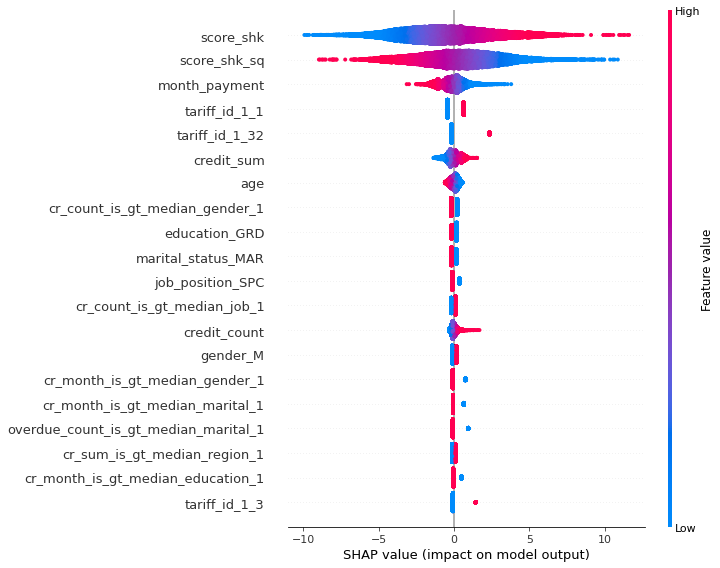

In [721]:
shap.summary_plot(shap_values, X_val_scaled_wcols_drop_3)

In [790]:
pd_tuned_lr_gr_wcols_drop_3 = pd.DataFrame(
    index=['intercept'] + X_val_scaled_wcols_drop_3.columns.to_list(),
    data=[tuned_lr_gr_wcols_drop_3.intercept_[0]] + tuned_lr_gr_wcols_drop_3.coef_[0].tolist(),
    columns=['coef_drop_3']).sort_values('coef_drop_3', ascending=False)

In [791]:
diff_cols_coef = diff_cols_coef.merge(pd_tuned_lr_gr_wcols_drop_3, how='left',
                                   left_index=True, right_index=True)

In [804]:
diff_cols_coef.query('-0.1 < coef_drop_3 < 0.1').index

Index(['tariff_id_1_22', 'tariff_id_1_6', 'education_SCH',
       'marital_status_WID', 'education_PGR', 'job_position_WRP',
       'marital_status_DIV', 'marital_status_UNM', 'tariff_id_1_5',
       'living_region_ЗАБАЙКАЛЬСКИЙ', 'tariff_id_1_23',
       'living_region_КРАСНОДАРСКИЙ', 'living_region_АМУРСКАЯ',
       'living_region_ТЮМЕНСКАЯ', 'living_region_ХАБАРОВСКИЙ',
       'living_region_МОСКОВСКАЯ', 'living_region_БУРЯТИЯ',
       'living_region_ИРКУТСКАЯ', 'living_region_ОМСКАЯ',
       'living_region_ОРЛОВСКАЯ', 'living_region_КРАСНОЯРСКИЙ',
       'living_region_КАЛУЖСКАЯ', 'living_region_ЧУВАШСКАЯ',
       'living_region_ТВЕРСКАЯ', 'living_region_АЛТАЙСКИЙ',
       'living_region_БЕЛГОРОДСКАЯ', 'living_region_ТУЛЬСКАЯ',
       'living_region_САНКТ-ПЕТЕРБУРГ'],
      dtype='object')

Видим, что теперь у нас нет сконструированных признаков с низким коэффициентом. Следовательно мы убрали лишние переменные.

Также можно проверить как изменится предсказательная сила переменной при удалении `score_shk_sq`.

In [794]:
X_tr_scaled_wcols_drop_4 = X_tr_scaled_wcols_drop_3.drop('score_shk_sq', axis=1)
X_val_scaled_wcols_drop_4 = X_val_scaled_wcols_drop_3.drop('score_shk_sq', axis=1)
X_test_scaled_wcols_drop_4 = X_test_scaled_wcols_drop_3.drop('score_shk_sq', axis=1)

In [795]:
tuned_lr_gr_wcols_drop_4 = LogisticRegression(class_weight='balanced',
                                             random_state=RND_STATE, max_iter=700,
                                             penalty='l1', solver='liblinear')
tuned_lr_gr_wcols_drop_4.fit(X_tr_scaled_wcols_drop_4, y_train)

y_pred_wcols_drop_4 = tuned_lr_gr_wcols_drop_4.predict(X_val_scaled_wcols_drop_4)
y_score_wcols_drop_4 = tuned_lr_gr_wcols_drop_4.predict_proba(X_val_scaled_wcols_drop_4)[:,1]

In [796]:
lr_metrics['lr_drop_shk_sq'] = [roc_auc_score(y_valid, y_score_wcols_drop_4),
                      precision_score(y_valid, y_pred_wcols_drop_4),
                      recall_score(y_valid, y_pred_wcols_drop_4),
                      f1_score(y_valid, y_pred_wcols_drop_4),
                      log_loss(y_valid, y_pred_wcols_drop_4)]

In [797]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

,lr_baseline,lr_baseline_grid,lr_baseline_wcols,lr_wcols_nocorr,lr_wcols_nocorr_1000,lr_wcols_1000,Grid_LR_wcols_denddrop,lr_denddrop,Grid_LR_ncorr,Grid_LR_wcols_C_lt1,lr_tuned_denddrop_C_lt1,lr_denddrop_2,lr_denddrop_2_l1,lr_denddrop_3_l1,lr_drop_shk_sq
roc-auc,0.728513,0.728714,0.741307,0.740677,0.741860,0.728513,0.742285,0.741915,0.742074,0.741915,0.741915,0.741690,0.741609,0.741543,0.738173
precision,0.303923,0.304025,0.316309,0.315298,0.316952,0.303923,0.315301,0.315353,0.316763,0.315353,0.315353,0.315833,0.316012,0.315890,0.312975
recall,0.645465,0.646151,0.654037,0.654380,0.656780,0.645465,0.652494,0.652494,0.657638,0.652494,0.652494,0.653866,0.654723,0.654037,0.649237
f1,0.413259,0.413494,0.426400,0.425553,0.427567,0.413259,0.425156,0.425204,0.427576,0.425204,0.425204,0.425931,0.426275,0.426019,0.422350
logloss,10.922295,10.923317,10.486056,10.527944,10.479927,10.922295,10.514662,10.512619,10.493208,10.512619,10.512619,10.503424,10.502403,10.502403,10.583111


In [798]:
explainer = shap.LinearExplainer(tuned_lr_gr_wcols_drop_4,
                                 X_tr_scaled_wcols_drop_4,
                                 feature_perturbation="interventional")
shap_values = explainer(X_val_scaled_wcols_drop_4)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


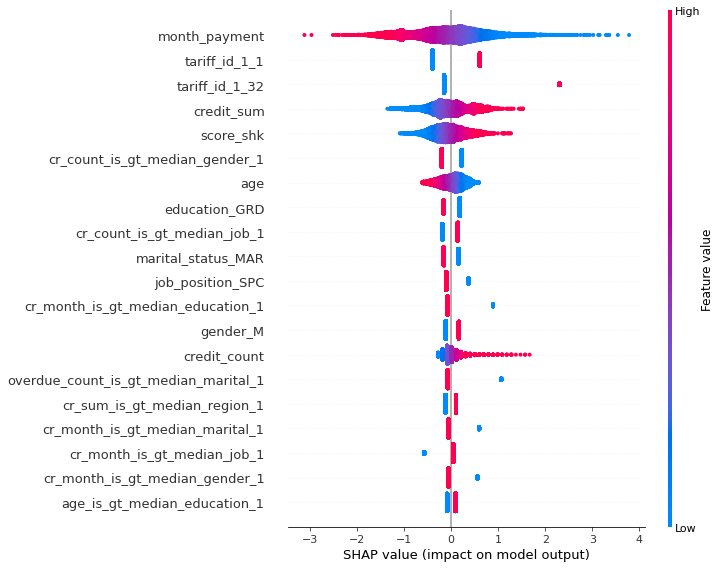

In [799]:
shap.summary_plot(shap_values, X_val_scaled_wcols_drop_4)

In [800]:
pd_tuned_lr_gr_wcols_drop_4 = pd.DataFrame(
    index=['intercept'] + X_val_scaled_wcols_drop_4.columns.to_list(),
    data=[tuned_lr_gr_wcols_drop_4.intercept_[0]] + tuned_lr_gr_wcols_drop_4.coef_[0].tolist(),
    columns=['coef_drop_4']).sort_values('coef_drop_4', ascending=False)

In [801]:
diff_cols_coef = diff_cols_coef.merge(pd_tuned_lr_gr_wcols_drop_4, how='left',
                                   left_index=True, right_index=True)

In [860]:
diff_cols_coef

,coef,coef_drop,coef_drop_l1_x,coef_drop_l1_y,coef_drop_3,coef_drop_4
score_shk,3.995040,4.022854,4.143839,4.143839,4.146952,0.454319
tariff_id_1_99,2.569717,2.573047,2.716599,2.716599,2.715197,2.701035
tariff_id_1_32,2.488013,2.489112,2.514658,2.514658,2.512629,2.451264
tariff_id_1_91,1.895905,1.909914,1.950125,1.950125,1.950997,1.893215
tariff_id_1_25,1.872158,1.918382,2.027139,2.027139,2.027911,2.034124
...,...,...,...,...,...,...
living_region_ТАМБОВСКАЯ,-0.867378,-0.886862,-0.669585,-0.669585,-0.669214,-0.675376
intercept,-0.880010,-0.955971,-1.201332,-1.201332,-1.218989,-1.075981
living_region_ВОЛОГОДСКАЯ,-0.923705,-0.942792,-0.722677,-0.722677,-0.722684,-0.753801
score_shk_sq,-3.557948,-3.554418,-3.673797,-3.673797,-3.657952,NaN


Согласно полученным результатам, можно заключить, что удаление столбца `score_shk_sq` приводит ко значительному ухудшению предсказательной способности модели. Значения Шепли при этом также уменьшаются в абсолютном значении в 3 раза.

Подытожив, можно сказать, что наилучшая в плане предсказательной способности и интерпретируемости модель это `tuned_lr_gr_wcols_drop_3`. Ее и будем дальше оптимизировать на сетке гиперпараметров.

In [847]:
parameters_grid = {
    'penalty': ['l1', 'l2' 'elasticnet'],
    'C': np.linspace(0, 1, num=6),
    'solver': ['sag', 'saga', 'lbfgs', 'liblinear'],
    'l1_ratio': [0.2, 0.4, 0.6, 0.8],
    'max_iter': np.arange(100, 700, 100)
}

tuned_lr_wcols_drop_3 = LogisticRegression(class_weight='balanced',
                              random_state=RND_STATE)

strat_cv = StratifiedKFold(n_splits=5, shuffle=True)
grid_cv_wcols_drop_3 = GridSearchCV(tuned_lr_wcols_drop_3,
                                    parameters_grid,
                                    scoring='roc_auc',
                                    cv=strat_cv,
                                    verbose=2,
                                    n_jobs=-1)

In [848]:
!telegram-send "grid_cv_wcols_drop_3 optimization started!"

In [849]:
%%time
# производим обучение по сетке
grid_cv_wcols_drop_3.fit(X_tr_scaled_wcols_drop_3, y_train)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


One or more of the test scores are non-finite: [       nan 0.5               nan ... 0.74334154        nan        nan]


Wall time: 3h 1min 37s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=777),
             n_jobs=-1,
             param_grid={'C': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
                         'l1_ratio': [0.2, 0.4, 0.6, 0.8],
                         'max_iter': array([100, 200, 300, 400, 500, 600]),
                         'penalty': ['l1', 'elasticnet'],
                         'solver': ['sag', 'saga', 'lbfgs', 'liblinear']},
             scoring='roc_auc', verbose=2)

In [850]:
!telegram-send "grid_cv_wcols_drop_3 optimization is over!"

In [851]:
print(grid_cv_wcols_drop_3.best_score_)
print(grid_cv_wcols_drop_3.best_params_)

0.7433587275887256
{'C': 1.0, 'l1_ratio': 0.2, 'max_iter': 200, 'penalty': 'elasticnet', 'solver': 'saga'}


In [852]:
best_params_wcols_drop_3 = grid_cv_wcols_drop_3.best_params_

In [853]:
# best_params_wcols = {'C': 1.0, 
#                    'l1_ratio': 0.2,
#                    'max_iter': 400, 
#                    'penalty': 'l2', 
#                    'solver': 'liblinear'}

In [854]:
tuned_lr_gr_wcols_drop_3 = LogisticRegression(**best_params_wcols_drop_3,
                                              class_weight='balanced',
                                              random_state=RND_STATE)

tuned_lr_gr_wcols_drop_3.fit(X_tr_scaled_wcols_drop_3, y_train)

y_pred_tuned_wcols_drop_3 = tuned_lr_gr_wcols_drop_3.predict(X_val_scaled_wcols_drop_3)
y_score_tuned_wcols_drop_3 = tuned_lr_gr_wcols_drop_3.predict_proba(X_val_scaled_wcols_drop_3)[:,1]

In [855]:
lr_metrics['Grid_LR_wcols_drop_3_tuned'] = [roc_auc_score(y_valid, y_score_tuned_wcols_drop_3),
                                              precision_score(y_valid, y_pred_tuned_wcols_drop_3),
                                              recall_score(y_valid, y_pred_tuned_wcols_drop_3),
                                              f1_score(y_valid, y_pred_tuned_wcols_drop_3),
                                              log_loss(y_valid, y_pred_tuned_wcols_drop_3)]

In [856]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

,lr_baseline,lr_baseline_grid,lr_baseline_wcols,lr_wcols_nocorr,lr_wcols_nocorr_1000,lr_wcols_1000,Grid_LR_wcols_denddrop,lr_denddrop,Grid_LR_ncorr,Grid_LR_wcols_C_lt1,lr_tuned_denddrop_C_lt1,lr_denddrop_2,lr_denddrop_2_l1,lr_denddrop_3_l1,lr_drop_shk_sq,lr_denddrop_3_l1_1,Grid_LR_wcols_drop_3_tuned
roc-auc,0.728513,0.728714,0.741307,0.740677,0.741860,0.728513,0.742285,0.741915,0.742074,0.741915,0.741915,0.741690,0.741609,0.741543,0.738173,0.721982,0.741607
precision,0.303923,0.304025,0.316309,0.315298,0.316952,0.303923,0.315301,0.315353,0.316763,0.315353,0.315353,0.315833,0.316012,0.315890,0.312975,0.296308,0.316069
recall,0.645465,0.646151,0.654037,0.654380,0.656780,0.645465,0.652494,0.652494,0.657638,0.652494,0.652494,0.653866,0.654723,0.654037,0.649237,0.656266,0.653866
f1,0.413259,0.413494,0.426400,0.425553,0.427567,0.413259,0.425156,0.425204,0.427576,0.425204,0.425204,0.425931,0.426275,0.426019,0.422350,0.408276,0.426145
logloss,10.922295,10.923317,10.486056,10.527944,10.479927,10.922295,10.514662,10.512619,10.493208,10.512619,10.512619,10.503424,10.502403,10.502403,10.583111,11.336060,10.494229


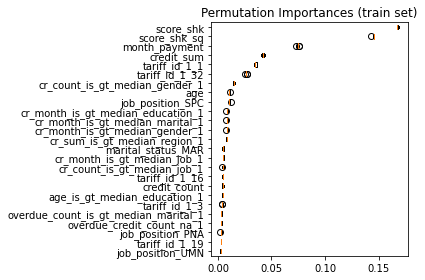

In [857]:
perm_imp_train = permutation_importance(tuned_lr_gr_wcols_drop_3,
                                        X_tr_scaled_wcols_drop_3,
                                        y_train,
                                        n_repeats=10,
                                        random_state=RND_STATE)

sorted_idx = perm_imp_train.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_train.importances[sorted_idx][-25:].T, vert=False,
    labels=X_tr_scaled_wcols_drop_3.columns[sorted_idx][-25:]
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

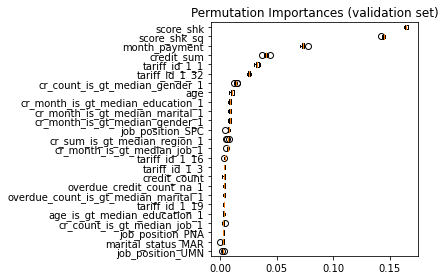

In [858]:
perm_imp_test = permutation_importance(tuned_lr_gr_wcols_drop_3,
                                       X_val_scaled_wcols_drop_3,
                                       y_valid,
                                       n_repeats=10,
                                       random_state=RND_STATE)

sorted_idx = perm_imp_test.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_test.importances[sorted_idx][-25:].T, vert=False,
    labels=X_val_scaled_wcols_drop_3.columns[sorted_idx][-25:]
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

$logit(p) = log(\frac{p}{1-p}) = \beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k.$

# Конструирование попарных взаимодействий

До этого момента в моделях не были заложены попарные взаимодействия между предикторами, также для улучшения предсказательной способности модели произведем биннинг некоторых количественных переменных. 

Для оценки качества и целесообразности биннинга переменных воспользуемся библиотекой [PyWoE](https://pypi.org/project/pywoe/).

In [4]:
datasets_path = ["Train_wo_na.csv", "Valid_wo_na.csv", "Control_wo_na.csv"]

train = pd.read_csv(fr'Data\{datasets_path[0]}', encoding='cp1251', index_col = 0).copy()
valid = pd.read_csv(fr'Data\{datasets_path[1]}', encoding='cp1251', index_col = 0).copy()
test = pd.read_csv(fr'Data\{datasets_path[2]}', encoding='cp1251', index_col = 0).copy()

In [5]:
X_train = train.drop('open_account_flg', axis=1)
y_train = train['open_account_flg']

X_valid = valid.drop('open_account_flg', axis=1)
y_valid = valid['open_account_flg']

X_test = test.drop('open_account_flg', axis=1)
y_test = test['open_account_flg']

In [6]:
X_train.dtypes

gender                   object
age                     float64
marital_status           object
job_position             object
credit_sum              float64
credit_month              int64
tariff_id                object
score_shk               float64
education                object
living_region            object
monthly_income          float64
credit_count            float64
overdue_credit_count    float64
month_payment           float64
payment_income_part     float64
dtype: object

In [7]:
qua_cols = X_train.dtypes[X_train.dtypes != 'object'].index

In [8]:
(X_train[qua_cols] == 0).sum()

age                          0
credit_sum                   0
credit_month                 0
score_shk                    1
monthly_income               0
credit_count             18079
overdue_credit_count    107843
month_payment                0
payment_income_part          0
dtype: int64

In [9]:
X_train[qua_cols] = X_train[qua_cols] - 0.001
(X_train[qua_cols] == 0).sum()

age                     0
credit_sum              0
credit_month            0
score_shk               0
monthly_income          0
credit_count            0
overdue_credit_count    0
month_payment           0
payment_income_part     0
dtype: int64

In [10]:
Xs_datasets = [X_train, X_valid, X_test]

In [11]:
for indicator in tqdm(qua_cols):
    for df in Xs_datasets:
        df[indicator + '_sq'] = df[indicator] ** 2
        df[indicator + '_inv'] = (1 / df[indicator]).replace([np.inf, -np.inf], -1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 141.00it/s]


In [12]:
qua_cols = X_train.dtypes[X_train.dtypes != 'object'].index

In [13]:
X_train[qua_cols]

,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count,month_payment,payment_income_part,age_sq,...,monthly_income_sq,monthly_income_inv,credit_count_sq,credit_count_inv,overdue_credit_count_sq,overdue_credit_count_inv,month_payment_sq,month_payment_inv,payment_income_part_sq,payment_income_part_inv
96462,29.999,23479.999,11.999,0.481145,33999.999,2.999,-0.001,1956.665667,0.056549,899.940001,...,1.156000e+09,0.000029,8.994001,0.333444,0.000001,-1000.0,3.828541e+06,0.000511,0.003198,17.683773
32152,30.999,19463.999,11.999,0.371297,83999.999,8.999,-0.001,1621.999000,0.018310,960.938001,...,7.056000e+09,0.000012,80.982001,0.111123,0.000001,-1000.0,2.630881e+06,0.000617,0.000335,54.616385
170020,44.999,13317.999,9.999,0.338391,84999.999,-0.001,-0.001,1331.799000,0.014668,2024.910001,...,7.225000e+09,0.000012,0.000001,-1000.000000,0.000001,-1000.0,1.773689e+06,0.000751,0.000215,68.174527
71886,61.999,19428.999,12.999,0.484840,24689.999,-0.001,-0.001,1494.537462,0.059532,3843.876001,...,6.095961e+08,0.000041,0.000001,-1000.000000,0.000001,-1000.0,2.233642e+06,0.000669,0.003544,16.797650
5543,52.999,15364.999,9.999,0.337691,54999.999,1.999,-0.001,1536.499000,0.026936,2808.894001,...,3.025000e+09,0.000018,3.996001,0.500250,0.000001,-1000.0,2.360829e+06,0.000651,0.000726,37.124536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100597,24.999,56691.899,9.999,0.521781,34999.999,2.999,-0.001,5669.189000,0.160977,624.950001,...,1.225000e+09,0.000029,8.994001,0.333444,0.000001,-1000.0,3.213970e+07,0.000176,0.025914,6.212073
79262,24.999,8889.999,2.999,0.361306,39999.999,-0.001,-0.001,2963.332333,0.073083,624.950001,...,1.600000e+09,0.000025,0.000001,-1000.000000,0.000001,-1000.0,8.781339e+06,0.000337,0.005341,13.683010
1011,29.999,13693.999,5.999,0.529801,54999.999,-0.001,-0.001,2282.332333,0.040497,899.940001,...,3.025000e+09,0.000018,0.000001,-1000.000000,0.000001,-1000.0,5.209041e+06,0.000438,0.001640,24.693206
168093,30.999,51067.999,11.999,0.616275,54999.999,5.999,-0.001,4255.665667,0.076376,960.938001,...,3.025000e+09,0.000018,35.988001,0.166694,0.000001,-1000.0,1.811069e+07,0.000235,0.005833,13.093160


Далее проведем степенное преобразование [Йео-Джонсона](https://en.wikipedia.org/wiki/Power_transform), которое также допускает нулевые и отрицательные значения. Закон преобразования гласит:


<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/2a99e24c81226f3d0547c471281197ea265553c5">

In [14]:
rs = RobustScaler(with_scaling=True,
                  unit_variance=True)

rs.fit(X_train[qua_cols])

for df in Xs_datasets:
    df[qua_cols] = rs.transform(df[qua_cols])

In [15]:
pt = PowerTransformer(standardize=True,
                      method='yeo-johnson')

pt.fit(X_train[qua_cols])

for df in Xs_datasets:
    df[qua_cols] = pt.transform(df[qua_cols])

<AxesSubplot:>

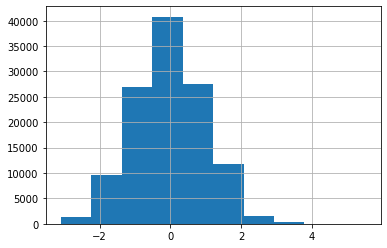

In [16]:
X_train['monthly_income'].hist()

В качестве меры целесообразности и качества биннинга будем использовать вес каждой категории (Weight of evidence - *WoE*), который может быть расчитан по формуле: <img src='https://4.bp.blogspot.com/-X1m0w40w0xg/V9V_7LS1AQI/AAAAAAAAFWc/f4bgPvE1In8Q13kGGBghp98MeWma8KgqACLcB/s1600/woe.png' img>
т.е. как логарифм отношения относительных частот двух классов в данной категории. Группировка выполняется так, чтобы максимизировать разницу между классами таргетной переменной.

При работе с данным показателем нужно придерживаться четырех правил:
* Количество категорий не должно превышать 10
* Каждая категория должна содержать не менее 5% наблюдений
* Категории не должны содержать нулевого окличества событий или не-событий
* Пропущенные значения группируются в отдельную категорию

Также стоит учесть, что в идеале *WoE* непропущенных значений должно быть монотонным, восходя от отрицательных значений к положительным или наоборот. Важно не столько абсолютное значение *WoE*, как разница между *WoE* групп. Чем больше разница между последующими категориями, тум выше прогнозная сила данной переменной.


In [17]:
import woe1

In [18]:
not_int_cols = qua_cols[~qua_cols.isin(['credit_month',
                                        'credit_month_sq',
                                        'credit_month_inv'])]

In [19]:
for col in not_int_cols:
    woe = woe1.WoE(qnt_num=10, min_block_size=10, v_type='c', t_type='b')
    # Зададим 10 бинов с не менее 10 записей, количественный предиктор и бинарный таргет.
    woe.fit(X_train[col], y_train.astype('int'))
    woe.transform(X_train[col])
    try:
        woe_mon = woe.force_monotonic()
    except:
        print(col, ' - unable to force_monotonic')
    print(f'\n{col}\n{woe_mon.bins}\n')


age
       mean    bad    obs   good       woe      bins labels
0  0.238800   5037  21093  16056 -0.380374      -inf      0
1  0.163255  16069  98429  82360  0.094562 -1.097765      1


credit_sum
       mean    bad    obs   good       woe      bins labels
0  0.274149   2980  10870   7890 -0.565973      -inf      0
1  0.180190  11750  65209  53459 -0.024584 -1.319058      1
2  0.171008   3716  21730  18014  0.038855  0.347207      2
3  0.125830   1365  10848   9483  0.398700  1.042982      3
4  0.119190   1295  10865   9570  0.460476  1.465042      4

score_shk  - unable to force_monotonic

score_shk
       mean    bad    obs   good       woe      bins labels
0  0.274149   2980  10870   7890 -0.565973      -inf      0
1  0.180190  11750  65209  53459 -0.024584 -1.319058      1
2  0.171008   3716  21730  18014  0.038855  0.347207      2
3  0.125830   1365  10848   9483  0.398700  1.042982      3
4  0.119190   1295  10865   9570  0.460476  1.465042      4


monthly_income
       mean   


payment_income_part_sq
       mean   bad    obs   good       woe      bins labels
0  0.214207  2328  10868   8540 -0.239895      -inf      0
1  0.201399  2188  10864   8676 -0.162073 -1.350195      1
2  0.193833  2106  10865   8759 -0.114355 -1.059717      2
3  0.187742  2040  10866   8826 -0.074894 -0.781858      3
4  0.179291  1948  10865   8917 -0.018490 -0.492497      4
5  0.177342  1927  10866   8939 -0.005187 -0.194039      5
6  0.174037  3782  21731  17949  0.017635  0.105951      6
7  0.160792  1747  10865   9118  0.112704  0.703122      7
8  0.150193  1632  10866   9234  0.193440  1.038117      8
9  0.129579  1408  10866   9458  0.365045  1.448664      9

payment_income_part_inv  - unable to force_monotonic

payment_income_part_inv
       mean   bad    obs   good       woe      bins labels
0  0.214207  2328  10868   8540 -0.239895      -inf      0
1  0.201399  2188  10864   8676 -0.162073 -1.350195      1
2  0.193833  2106  10865   8759 -0.114355 -1.059717      2
3  0.187742 

По результатам разбиения можно сказать, что для `age`, `overdue_credit_count` и `credit_count` и их производных биннинг не даст результатов, поскольку количество бинов - 2. Теперь оптимизируем бины  по метрике *roc_auc* с использованием CART.

In [20]:
bin_cols = ['credit_sum', 'score_shk', 'monthly_income',
            'month_payment', 'payment_income_part',
            'credit_sum_sq', 'credit_sum_inv', 'score_shk_sq',
            'score_shk_inv', 'monthly_income_sq', 'monthly_income_inv',
            'month_payment_sq', 'month_payment_inv',
            'payment_income_part_sq', 'payment_income_part_inv'] 

In [21]:
columns = []
fitted_bins = []
column_IV = []
bins_number = []

for col in bin_cols:
    woe = woe1.WoE(qnt_num=10, min_block_size=10, v_type='c', t_type='b')
    woe.fit(X_train[col], train['open_account_flg'].astype('int'))
    
    woe_optimized = woe.optimize(max_depth=4,
                                 scoring='roc_auc',
                                 cv=5,
                                 min_samples_leaf=50)
    columns.append(col)
    fitted_bins.append(woe_optimized.bins.bins.values)
    column_IV.append(woe_optimized.iv)
    bins_number.append(woe_optimized.bins.bins.shape[0])
    
binning_info = pd.DataFrame({'Переменная':columns,
                             'Бины':fitted_bins,
                             'IV':column_IV,
                             'Количество бинов':bins_number})\
                            .sort_values('IV', ascending=False)\
                            .set_index('Переменная')

In [22]:
binning_info

,Бины,IV,Количество бинов
Переменная,,,
credit_sum,"[-inf, -2.3381190299987793, -1.815609991550445...",0.076785,8
credit_sum_sq,"[-inf, -1.7598434090614319, -1.581402778625488...",0.076785,8
credit_sum_inv,"[-inf, -1.8884193897247314, -1.160144269466400...",0.076785,8
month_payment,"[-inf, -1.9194981455802917, -1.349827170372009...",0.072848,8
month_payment_sq,"[-inf, -1.6392126083374023, -1.325709164142608...",0.072848,8
month_payment_inv,"[-inf, -2.1851274967193604, -1.268577873706817...",0.072848,8
score_shk,"[-inf, -2.5924123525619507, -0.486593723297119...",0.031557,8
score_shk_sq,"[-inf, -2.3159795999526978, -0.511229008436203...",0.031557,8
score_shk_inv,"[-inf, -1.1064246892929077, -0.964150637388229...",0.031490,8


Нашей задачей является категоризация переменной при условии максимально эффективного разделения одного класса от другого. Существует возможность разбить все переменные на множество категорий, однако, это чревато переобучением и усложнием модели. Возможным вариантом является сравнение "полезности" предиктора с остальными переменными. Самый простой вариант - использовать IV (от [information value](https://www.analyticsvidhya.com/blog/2021/06/understand-weight-of-evidence-and-information-value/)) или информационное значение. Его можно вычислить для отдельной категории и для всей переменной. Информационное значение для категории вычисляется как разность между относительной частотой класса 0 и относительной частотой класса 1 в данной категории, умноженная на натуральный логарифм отношения этих частот.

$ IV = \sum_{i = 1}^k(IV_i) = \sum_{i = 1}^k(F_i^0 - F_i^1)ln(\frac{F_i^0}{F_i^1})$




<table  width="50%" cellspacing="2" style="margin: 0px auto;">
    <tbody>
        <tr>
            <th>Information Value</th>
            <th>Предсказательная способность</th>
        </tr>
        <tr>
            <td>&lt;0.02</td>
            <th>не обладает</th>
        </tr>
        <tr>
            <td>0.02-0.1</td>
            <th>слабая</th>
        </tr>
        <tr>
            <td>0.1-0.3</td>
            <th>средняя</th>
        </tr>
        <tr>
            <td>0.3-0.5</td>
            <th>сильная</th>
        </tr>
        <tr>
            <td>&gt;0.5</td>
            <th>подозрительная (утечка?)</th>
        </tr>
    </tbody>
</table>


Отбросим `monthly_income_sq` и `monthly_income_inv` поскольку они не обладают никакой предсказательной силой. Для остальных переменных создадим соответствующие категории на основе полученных бинов.

In [23]:
for indicator in tqdm(['monthly_income_sq', 'monthly_income_inv']):
    for df in Xs_datasets:
        df.drop(indicator, axis=1, inplace=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 28.65it/s]


In [24]:
cols_to_categorize = binning_info[binning_info.IV > 0.02].index

for col in cols_to_categorize:
    for df in Xs_datasets:
        df[col + '_cat'] = pd.cut(df[col], binning_info.loc[col,'Бины']).astype('object')

In [25]:
cat_cols = X_train.dtypes[X_train.dtypes == 'object'].index

In [40]:
X_train_label = pd.get_dummies(X_train, columns=cat_cols, drop_first=True).copy()
X_valid_label = pd.get_dummies(X_valid, columns=cat_cols, drop_first=True).copy()
X_test_label = pd.get_dummies(X_test, columns=cat_cols, drop_first=True).copy()

In [41]:
labeled_Xs_datasets = [X_train_label, X_valid_label, X_test_label]

## Построение модели с категориями количественных переменных

In [42]:
lr_baseline_cat = LogisticRegression(class_weight = 'balanced',
                                 random_state=RND_STATE, max_iter=2000)
lr_baseline_cat.fit(X_train_label, y_train)

y_pred_cat = lr_baseline_cat.predict(X_valid_label)

In [43]:
y_score_cat = lr_baseline_cat.predict_proba(X_valid_label)[:,1]

In [44]:
lr_metrics_cat = pd.DataFrame(index=['roc-auc', 'precision',
                                 'recall', 'f1', 'logloss'])

lr_metrics_cat['lr_baseline_cat'] = [roc_auc_score(y_valid, y_score_cat),
                                      precision_score(y_valid, y_pred_cat),
                                      recall_score(y_valid, y_pred_cat),
                                      f1_score(y_valid, y_pred_cat),
                                      log_loss(y_valid, y_pred_cat)]

In [45]:
lr_metrics_cat

,lr_baseline_cat
roc-auc,0.746827
precision,0.276043
recall,0.801817
f1,0.410695
logloss,13.712413


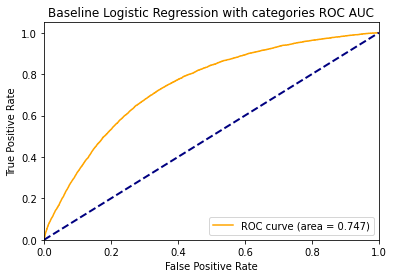

In [46]:
fpr_baseline, tpr_baseline, thresholds = roc_curve(y_valid, y_score_cat)

roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

plt.plot(fpr_baseline, tpr_baseline, color='orange',
         label=f'ROC curve (area = {roc_auc_baseline:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Baseline Logistic Regression with categories ROC AUC')
plt.legend(loc="lower right")
plt.show()

## Построение взаимодействия категории и значения переменных

Как можно заметить, мы увеличили характеристику ROC AUC за счет добавления новых переменных, т.о. мы создали модель логистической регрессии с дискретизированными признаками и одним глобальным наклоном гиперплоскости, теперь можно включить взаимодействие, указывающее на категорию точки данных и ее точное расположение по данной оси в пространстве - произведение индикатора категории и исходной переменной.

In [47]:
for df in labeled_Xs_datasets:    
    for qua_col in cols_to_categorize:
        cols_to_mul = [col for col in df.columns
                       if (qua_col + '_cat') in col]
        for cat_col in cols_to_mul:
            df[cat_col + '_mul'] = df[qua_col] * df[cat_col]
        df.drop(qua_col, axis=1, inplace=True)

## Построение модели с взаимодействием категорий и количественных переменных

In [48]:
lr_qua_cat = LogisticRegression(class_weight = 'balanced',
                                 random_state=RND_STATE, max_iter=1000)
lr_qua_cat.fit(X_train_label, y_train)

y_pred_qua_cat = lr_qua_cat.predict(X_valid_label)

In [49]:
y_score_qua_cat = lr_qua_cat.predict_proba(X_valid_label)[:,1]

In [50]:
lr_metrics_cat['lr_qua_cat_wo_drop'] = [roc_auc_score(y_valid, y_score_qua_cat),
                                      precision_score(y_valid, y_pred_qua_cat),
                                      recall_score(y_valid, y_pred_qua_cat),
                                      f1_score(y_valid, y_pred_qua_cat),
                                      log_loss(y_valid, y_pred_qua_cat)]

In [51]:
lr_metrics_cat

,lr_baseline_cat,lr_qua_cat_wo_drop
roc-auc,0.746827,0.747208
precision,0.276043,0.276818
recall,0.801817,0.804732
f1,0.410695,0.411935
logloss,13.712413,13.691981


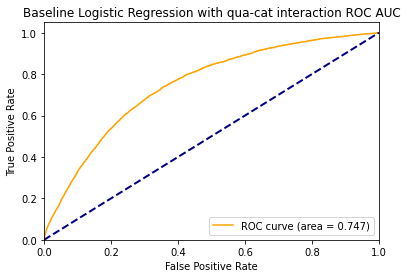

In [52]:
fpr_baseline, tpr_baseline, thresholds = roc_curve(y_valid, y_score_qua_cat)

roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

plt.plot(fpr_baseline, tpr_baseline, color='orange',
         label=f'ROC curve (area = {roc_auc_baseline:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Baseline Logistic Regression with qua-cat interaction ROC AUC')
plt.legend(loc="lower right")
plt.show()

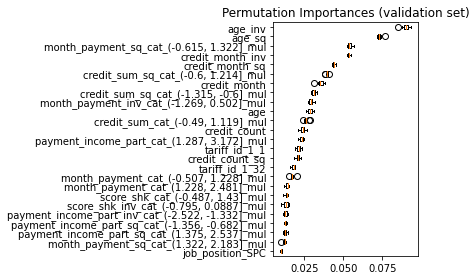

In [53]:
perm_imp_test = permutation_importance(lr_qua_cat,
                                       X_valid_label,
                                       y_valid,
                                       n_repeats=10,
                                       random_state=RND_STATE)

sorted_idx = perm_imp_test.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_test.importances[sorted_idx][-25:].T, vert=False,
    labels=X_valid_label.columns[sorted_idx][-25:]
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

## Снижение размерности путем отсеивания признаков


На данном этапе отбираем признаки по их важности, для этого воспользуемся рекурсивным удалением признаков с перекрестной проверкой, которая реализована в классе RFECV библиотеки scikit-learn.

In [54]:
from sklearn.feature_selection import RFECV

lr_qua_cat_2 = LogisticRegression(class_weight='balanced',
                                  random_state=RND_STATE)

rfecv = RFECV(lr_qua_cat_2,
              scoring='roc_auc',
              n_jobs=-1,
              verbose=5)

In [55]:
rfecv.fit(X_train_label, y_train)

Fitting estimator with 283 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 282 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 281 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 280 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 279 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 278 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 277 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 276 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 275 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 274 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 273 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 272 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 271 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 270 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 269 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 268 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 267 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 266 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 265 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 264 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 263 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 262 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 261 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 260 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 259 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 258 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 257 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 256 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 255 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 254 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 253 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

RFECV(estimator=LogisticRegression(class_weight='balanced', random_state=777),
      n_jobs=-1, scoring='roc_auc', verbose=5)

In [56]:
print(rfecv.n_features_)
print(X_train_label.loc[:,rfecv.support_].columns)

252
Index(['age', 'credit_month', 'monthly_income', 'credit_count',
       'overdue_credit_count', 'age_sq', 'age_inv', 'credit_month_sq',
       'credit_month_inv', 'credit_count_sq',
       ...
       'payment_income_part_sq_cat_(0.547, 0.549]_mul',
       'payment_income_part_sq_cat_(0.549, 1.371]_mul',
       'payment_income_part_sq_cat_(1.371, 1.375]_mul',
       'payment_income_part_sq_cat_(1.375, 2.537]_mul',
       'payment_income_part_inv_cat_(-2.522, -1.332]_mul',
       'payment_income_part_inv_cat_(-1.332, -1.328]_mul',
       'payment_income_part_inv_cat_(-1.328, -0.51]_mul',
       'payment_income_part_inv_cat_(-0.51, -0.508]_mul',
       'payment_income_part_inv_cat_(-0.508, 0.556]_mul',
       'payment_income_part_inv_cat_(0.556, 1.337]_mul'],
      dtype='object', length=252)


In [57]:
# predictive_cols = ['age', 'credit_sum', 'credit_month', 'score_shk',
#                    'monthly_income', 'credit_count', 'overdue_credit_count',
#                    'month_payment', 'age_sq', 'age_inv', 'credit_sum_sq',
#                    'credit_sum_inv', 'credit_month_sq', 'credit_month_inv',
#                    'score_shk_inv', 'credit_count_sq', 'overdue_credit_count_sq',
#                    'month_payment_inv', 'payment_income_part_sq', 'payment_income_part_inv',
#                    'gender_M', 'marital_status_MAR', 'job_position_BIS', 'job_position_BIU',
#                    'job_position_DIR', 'job_position_INP', 'job_position_NOR',
#                    'job_position_PNA', 'job_position_PNI', 'job_position_SPC',
#                    'job_position_UMN', 'job_position_WRK', 'job_position_WRP',
#                    'tariff_id_1_1', 'tariff_id_1_16', 'tariff_id_1_17',
#                    'tariff_id_1_19', 'tariff_id_1_2', 'tariff_id_1_21',
#                    'tariff_id_1_23', 'tariff_id_1_24', 'tariff_id_1_25',
#                    'tariff_id_1_3', 'tariff_id_1_32', 'tariff_id_1_41',
#                    'tariff_id_1_43', 'tariff_id_1_5', 'tariff_id_1_7',
#                    'tariff_id_1_9', 'tariff_id_1_91', 'tariff_id_1_99',
#                    'education_PGR', 'education_SCH', 'living_region_АДЫГЕЯ',
#                    'living_region_АСТРАХАНСКАЯ', 'living_region_БАШКОРТОСТАН',
#                    'living_region_ВЛАДИМИРСКАЯ', 'living_region_ВОЛОГОДСКАЯ',
#                    'living_region_ДАГЕСТАН', 'living_region_ЕВРЕЙСКАЯ',
#                    'living_region_КАБАРДИНО-БАЛКАРСКАЯ', 'living_region_КАЛИНИНГРАДСКАЯ',
#                    'living_region_КАЛМЫКИЯ', 'living_region_КАРАЧАЕВО-ЧЕРКЕССКАЯ',
#                    'living_region_КАРЕЛИЯ', 'living_region_КОСТРОМСКАЯ',
#                    'living_region_КУРГАНСКАЯ', 'living_region_ЛИПЕЦКАЯ',
#                    'living_region_МАГАДАНСКАЯ', 'living_region_МАРИЙЭЛ',
#                    'living_region_МОРДОВИЯ', 'living_region_МОСКВА',
#                    'living_region_МУРМАНСКАЯ', 'living_region_НЕ УКАЗАН',
#                    'living_region_НЕНЕЦКИЙ', 'living_region_НИЖЕГОРОДСКАЯ',
#                    'living_region_НОВГОРОДСКАЯ', 'living_region_ОРЕНБУРГСКАЯ',
#                    'living_region_ПЕНЗЕНСКАЯ', 'living_region_ПЕРМСКИЙ',
#                    'living_region_ПРИМОРСКИЙ', 'living_region_ПСКОВСКАЯ',
#                    'living_region_РЯЗАНСКАЯ', 'living_region_САМАРСКАЯ',
#                    'living_region_САРАТОВСКАЯ', 'living_region_САХА/ЯКУТИЯ/',
#                    'living_region_САХАЛИНСКАЯ', 'living_region_СВЕРДЛОВСКАЯ',
#                    'living_region_СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ', 'living_region_СМОЛЕНСКАЯ',
#                    'living_region_СТАВРОПОЛЬСКИЙ', 'living_region_ТАМБОВСКАЯ',
#                    'living_region_ТАТАРСТАН', 'living_region_ТОМСКАЯ',
#                    'living_region_ТЫВА', 'living_region_УЛЬЯНОВСКАЯ',
#                    'living_region_ХАКАСИЯ', 'living_region_ЯМАЛО-НЕНЕЦКИЙ',
#                    'living_region_ЯРОСЛАВСКАЯ', 'credit_sum_cat_(-1.33, -0.49]',
#                    'credit_sum_cat_(-0.49, 1.119]', 'credit_sum_cat_(1.119, 2.016]',
#                    'credit_sum_sq_cat_(-1.315, -0.6]', 'credit_sum_sq_cat_(-0.6, 1.214]',
#                    'credit_sum_sq_cat_(1.214, 1.922]', 'credit_sum_inv_cat_(-1.888, -1.16]',
#                    'credit_sum_inv_cat_(-1.16, 0.486]', 'credit_sum_inv_cat_(0.486, 1.27]',
#                    'month_payment_cat_(-1.919, -1.35]', 'month_payment_cat_(-1.096, -0.507]',
#                    'month_payment_cat_(-0.507, 1.228]', 'month_payment_cat_(1.228, 2.481]',
#                    'month_payment_sq_cat_(-1.639, -1.326]', 'month_payment_sq_cat_(-1.144, -0.615]',
#                    'month_payment_sq_cat_(-0.615, 1.322]', 'month_payment_sq_cat_(1.322, 2.183]',
#                    'month_payment_inv_cat_(-2.185, -1.269]', 'month_payment_inv_cat_(-1.269, 0.502]',
#                    'month_payment_inv_cat_(0.502, 1.038]', 'month_payment_inv_cat_(1.102, 1.29]',
#                    'month_payment_inv_cat_(1.29, 1.963]', 'score_shk_cat_(1.43, 1.847]',
#                    'score_shk_cat_(2.197, 3.088]', 'score_shk_sq_cat_(1.433, 1.831]',
#                    'score_shk_sq_cat_(2.162, 2.996]', 'score_shk_inv_cat_(-1.106, -0.964]',
#                    'score_shk_inv_cat_(-0.894, -0.795]', 'score_shk_inv_cat_(0.0887, 5.137]',
#                    'payment_income_part_cat_(0.504, 0.505]', 'payment_income_part_sq_cat_(0.547, 0.549]',
#                    'payment_income_part_inv_cat_(-0.51, -0.508]', 'credit_sum_cat_(-2.338, -1.816]_mul',
#                    'credit_sum_cat_(-1.816, -1.516]_mul', 'credit_sum_cat_(-1.516, -1.33]_mul',
#                    'credit_sum_cat_(-0.49, 1.119]_mul', 'credit_sum_sq_cat_(-1.76, -1.581]_mul',
#                    'credit_sum_sq_cat_(-1.581, -1.429]_mul', 'credit_sum_sq_cat_(-1.429, -1.315]_mul',
#                    'credit_sum_inv_cat_(-1.16, 0.486]_mul', 'credit_sum_inv_cat_(1.27, 1.471]_mul',
#                    'credit_sum_inv_cat_(1.471, 1.836]_mul', 'month_payment_cat_(-1.919, -1.35]_mul',
#                    'month_payment_cat_(-1.096, -0.507]_mul', 'month_payment_cat_(1.228, 2.481]_mul',
#                    'month_payment_sq_cat_(-1.144, -0.615]_mul', 'month_payment_sq_cat_(-0.615, 1.322]_mul',
#                    'month_payment_inv_cat_(-1.269, 0.502]_mul', 'month_payment_inv_cat_(0.502, 1.038]_mul',
#                    'month_payment_inv_cat_(1.29, 1.963]_mul', 'score_shk_cat_(-0.487, 1.43]_mul',
#                    'score_shk_cat_(1.43, 1.847]_mul', 'score_shk_cat_(1.847, 2.181]_mul',
#                    'score_shk_sq_cat_(1.831, 2.146]_mul', 'score_shk_inv_cat_(-1.106, -0.964]_mul',
#                    'score_shk_inv_cat_(-0.795, 0.0887]_mul', 'payment_income_part_cat_(1.283, 1.287]_mul',
#                    'payment_income_part_sq_cat_(1.371, 1.375]_mul',
#                    'payment_income_part_inv_cat_(-1.332, -1.328]_mul']

In [58]:
dropped = X_train_label.loc[:,~rfecv.support_].columns
print(dropped)

Index(['credit_count_inv', 'living_region_БРЯНСКАЯ',
       'living_region_ВОЛГОГРАДСКАЯ', 'living_region_ИВАНОВСКАЯ',
       'living_region_КИРОВСКАЯ', 'living_region_РОСТОВСКАЯ',
       'living_region_САНКТ-ПЕТЕРБУРГ', 'living_region_ТУЛЬСКАЯ',
       'living_region_УДМУРТСКАЯ', 'month_payment_inv_cat_(-2.185, -1.269]',
       'score_shk_sq_cat_(1.831, 2.146]', 'score_shk_inv_cat_(-0.961, -0.894]',
       'payment_income_part_cat_(-1.392, -0.558]',
       'payment_income_part_sq_cat_(1.375, 2.537]',
       'credit_sum_sq_cat_(-1.76, -1.581]_mul',
       'credit_sum_sq_cat_(-1.581, -1.429]_mul',
       'month_payment_cat_(-1.35, -1.162]_mul',
       'month_payment_cat_(-1.162, -1.096]_mul',
       'month_payment_cat_(-0.507, 1.228]_mul',
       'month_payment_sq_cat_(-1.639, -1.326]_mul',
       'month_payment_sq_cat_(-1.326, -1.194]_mul',
       'month_payment_sq_cat_(-1.194, -1.144]_mul',
       'month_payment_inv_cat_(1.038, 1.102]_mul',
       'month_payment_inv_cat_(1.102, 1.29]_

In [59]:
dropped[:20]

Index(['credit_count_inv', 'living_region_БРЯНСКАЯ',
       'living_region_ВОЛГОГРАДСКАЯ', 'living_region_ИВАНОВСКАЯ',
       'living_region_КИРОВСКАЯ', 'living_region_РОСТОВСКАЯ',
       'living_region_САНКТ-ПЕТЕРБУРГ', 'living_region_ТУЛЬСКАЯ',
       'living_region_УДМУРТСКАЯ', 'month_payment_inv_cat_(-2.185, -1.269]',
       'score_shk_sq_cat_(1.831, 2.146]', 'score_shk_inv_cat_(-0.961, -0.894]',
       'payment_income_part_cat_(-1.392, -0.558]',
       'payment_income_part_sq_cat_(1.375, 2.537]',
       'credit_sum_sq_cat_(-1.76, -1.581]_mul',
       'credit_sum_sq_cat_(-1.581, -1.429]_mul',
       'month_payment_cat_(-1.35, -1.162]_mul',
       'month_payment_cat_(-1.162, -1.096]_mul',
       'month_payment_cat_(-0.507, 1.228]_mul',
       'month_payment_sq_cat_(-1.639, -1.326]_mul'],
      dtype='object')

In [60]:
dropped[dropped.str.contains('payment_income_part')]

Index(['payment_income_part_cat_(-1.392, -0.558]',
       'payment_income_part_sq_cat_(1.375, 2.537]',
       'payment_income_part_cat_(-1.392, -0.558]_mul',
       'payment_income_part_cat_(0.505, 1.283]_mul'],
      dtype='object')

In [61]:
dropped[dropped.str.contains('living_region_')]

Index(['living_region_БРЯНСКАЯ', 'living_region_ВОЛГОГРАДСКАЯ',
       'living_region_ИВАНОВСКАЯ', 'living_region_КИРОВСКАЯ',
       'living_region_РОСТОВСКАЯ', 'living_region_САНКТ-ПЕТЕРБУРГ',
       'living_region_ТУЛЬСКАЯ', 'living_region_УДМУРТСКАЯ'],
      dtype='object')

In [62]:
dropped[dropped.str.contains('score_shk_sq')]

Index(['score_shk_sq_cat_(1.831, 2.146]',
       'score_shk_sq_cat_(1.831, 2.146]_mul',
       'score_shk_sq_cat_(2.162, 2.996]_mul'],
      dtype='object')

In [63]:
score_shk_not_dropped = set(X_train_label.columns[X_train_label.columns.str.contains('score_shk_sq')]) -\
                                      set(dropped[dropped.str.contains('score_shk_sq')])
list(score_shk_not_dropped)

['score_shk_sq_cat_(2.146, 2.162]',
 'score_shk_sq_cat_(1.433, 1.831]',
 'score_shk_sq_cat_(2.162, 2.996]',
 'score_shk_sq_cat_(-0.511, 1.433]_mul',
 'score_shk_sq_cat_(2.146, 2.162]_mul',
 'score_shk_sq_cat_(1.433, 1.831]_mul',
 'score_shk_sq_cat_(-2.316, -0.511]_mul',
 'score_shk_sq_cat_(-2.316, -0.511]',
 'score_shk_sq_cat_(-0.511, 1.433]']

In [64]:
X_train_label.loc[:,rfecv.support_].columns[X_train_label.loc[:,rfecv.support_].columns.str.contains('payment_income_part')]

Index(['payment_income_part_cat_(-0.558, 0.504]',
       'payment_income_part_cat_(0.504, 0.505]',
       'payment_income_part_cat_(0.505, 1.283]',
       'payment_income_part_cat_(1.283, 1.287]',
       'payment_income_part_cat_(1.287, 3.172]',
       'payment_income_part_sq_cat_(-1.356, -0.682]',
       'payment_income_part_sq_cat_(-0.682, 0.547]',
       'payment_income_part_sq_cat_(0.547, 0.549]',
       'payment_income_part_sq_cat_(0.549, 1.371]',
       'payment_income_part_sq_cat_(1.371, 1.375]',
       'payment_income_part_inv_cat_(-2.522, -1.332]',
       'payment_income_part_inv_cat_(-1.332, -1.328]',
       'payment_income_part_inv_cat_(-1.328, -0.51]',
       'payment_income_part_inv_cat_(-0.51, -0.508]',
       'payment_income_part_inv_cat_(-0.508, 0.556]',
       'payment_income_part_inv_cat_(0.556, 1.337]',
       'payment_income_part_cat_(-0.558, 0.504]_mul',
       'payment_income_part_cat_(0.504, 0.505]_mul',
       'payment_income_part_cat_(1.283, 1.287]_mul',
      

In [65]:
lr_qua_cat_rfe = LogisticRegression(class_weight = 'balanced',
                                    random_state=RND_STATE,
                                    max_iter=1000)

lr_qua_cat_rfe.fit(X_train_label.loc[:,rfecv.support_], y_train)

y_pred_qua_cat_rfe = lr_qua_cat_rfe.predict(X_valid_label.loc[:,rfecv.support_])

In [66]:
lr_qua_cat_rfe.n_iter_

array([701])

In [67]:
lr_qua_cat_rfe_coef = pd.DataFrame(index=X_train_label.loc[:,rfecv.support_].columns,
                                   data={'coef':lr_qua_cat_rfe.coef_[0]})

In [68]:
y_score_qua_cat_rfe = lr_qua_cat_rfe.predict_proba(X_valid_label.loc[:,rfecv.support_])[:,1]

In [69]:
lr_metrics_cat['lr_qua_cat_rfe'] = [roc_auc_score(y_valid, y_score_qua_cat_rfe),
                                      precision_score(y_valid, y_pred_qua_cat_rfe),
                                      recall_score(y_valid, y_pred_qua_cat_rfe),
                                      f1_score(y_valid, y_pred_qua_cat_rfe),
                                      log_loss(y_valid, y_pred_qua_cat_rfe)]

In [70]:
lr_metrics_cat

,lr_baseline_cat,lr_qua_cat_wo_drop,lr_qua_cat_rfe
roc-auc,0.746827,0.747208,0.747355
precision,0.276043,0.276818,0.278690
recall,0.801817,0.804732,0.799760
f1,0.410695,0.411935,0.413344
logloss,13.712413,13.691981,13.528518


Попробуем провести отброс параметров еще раз, но в этот раз передадим в линейную регрессию большее число итераций.

In [71]:
lr_qua_cat_3 = LogisticRegression(class_weight='balanced',
                                  random_state=RND_STATE,
                                  max_iter=800)

rfecv1 = RFECV(lr_qua_cat_3,
              scoring='roc_auc',
              n_jobs=-1,
              verbose=5)

In [72]:
rfecv1.fit(X_train_label.loc[:,rfecv.support_], y_train)

Fitting estimator with 252 features.
Fitting estimator with 251 features.
Fitting estimator with 250 features.
Fitting estimator with 249 features.
Fitting estimator with 248 features.
Fitting estimator with 247 features.
Fitting estimator with 246 features.


RFECV(estimator=LogisticRegression(class_weight='balanced', max_iter=800,
                                   random_state=777),
      n_jobs=-1, scoring='roc_auc', verbose=5)

In [73]:
print(rfecv.n_features_)
print(X_train_label.loc[:,rfecv.support_].columns)

252
Index(['age', 'credit_month', 'monthly_income', 'credit_count',
       'overdue_credit_count', 'age_sq', 'age_inv', 'credit_month_sq',
       'credit_month_inv', 'credit_count_sq',
       ...
       'payment_income_part_sq_cat_(0.547, 0.549]_mul',
       'payment_income_part_sq_cat_(0.549, 1.371]_mul',
       'payment_income_part_sq_cat_(1.371, 1.375]_mul',
       'payment_income_part_sq_cat_(1.375, 2.537]_mul',
       'payment_income_part_inv_cat_(-2.522, -1.332]_mul',
       'payment_income_part_inv_cat_(-1.332, -1.328]_mul',
       'payment_income_part_inv_cat_(-1.328, -0.51]_mul',
       'payment_income_part_inv_cat_(-0.51, -0.508]_mul',
       'payment_income_part_inv_cat_(-0.508, 0.556]_mul',
       'payment_income_part_inv_cat_(0.556, 1.337]_mul'],
      dtype='object', length=252)


Можно заметить, что это не принесло результатов. Таким образом, можно взять на заметку, что отсеивание переменных можно проводить при низком количестве итераций оптимизатора.


###  Кривая заучивания
С помощью данной кривой оценим эффект влияния количества наблюдений в тренировочном наборе на метрический показатель roc-auc.

In [74]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(max_iter=1000),
                                        X_train_label.loc[:,rfecv.support_],
                                        y_train,
                                        cv=7,
                                        scoring='roc_auc',
                                        n_jobs=-1,
                                        train_sizes=np.linspace(0.01, 1.0, 40))

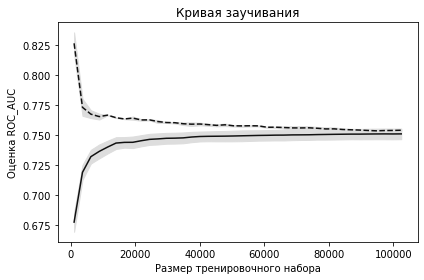

In [75]:
# Создать средние и стандартные отклонения оценок тренировочного набора
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
# Создать средние и стандартные отклонения оценок тестового набора
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Нанести линии
plt.plot(train_sizes, train_mean, "--", color="#111111",
         label="Тренировочная оценка")
plt.plot(train_sizes, test_mean, color="#111111",
         label="Перекрестно-проверочная оценка")
# Нанести полосы
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, color="#DDDDDD")
# Построить график
plt.title("Кривая заучивания")
plt.xlabel("Размер тренировочного набора")
plt.ylabel("Оценка ROC_AUC")
plt.tight_layout()

**Отвечаем на вопрос - выиграют ли наши обучающиеся алгоритмы от сбора дополнительных тренировочных данных?**

In [76]:
! telegram-send 'learning_curve ready'

###  Эффект значений гиперпараметра
На данном этапе постараемся разобраться в том, как результативность модели изменяется по мере изменения значений некоторого гиперпараметра. Для этого построим график валидационной кривой.

In [77]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(LogisticRegression(penalty='l1'),
                                            X_train_label.loc[:,rfecv.support_],
                                            y_train,
                                            param_name='C',
                                            param_range=np.linspace(0.1, 10., 40),
                                            cv=3,
                                            scoring='roc_auc',
                                            n_jobs=-1)

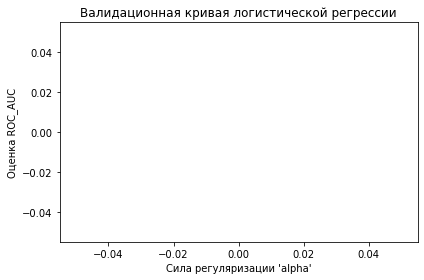

In [78]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
# Вычислить среднее и стандартное отклонение для оценок
# тестового набора
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Построить график средних оценок точности
# для тренировочного и тестового наборов
plt.plot(np.linspace(0.01, 2.0, 40), train_mean, color="black",
         label="Тренировочная оценка")
plt.plot(np.linspace(0.01, 2.0, 40), test_mean, color="dimgrey",
         label="Перекрестно-проверочная оценка")

# Нанести полосы точности для тренировочного и тестового наборов
plt.fill_between(np.linspace(0.01, 2.0, 40), train_mean - train_std,
                 train_mean + train_std, color="gray")
plt.fill_between(np.linspace(0.01, 2.0, 40), test_mean - test_std,
                 test_mean + test_std, color="gainsboro")

plt.title("Валидационная кривая логистической регрессии")
plt.xlabel("Сила регуляризации 'alpha'")
plt.ylabel("Оценка ROC_AUC")
plt.tight_layout()

In [79]:
! telegram-send 'validation_curve ready'

## Оптимизация модели с взаимодействием категорий и количественных переменных

In [80]:
# parameters_grid = {
#     'penalty': ['l1', 'l2' 'elasticnet'],
#     'C': np.linspace(0.1, 2, num=5),
#     'solver': ['sag', 'saga', 'lbfgs', 'liblinear'],
#     'l1_ratio': [0.2, 0.4, 0.6, 0.8],
#     'max_iter': np.arange(1000, 1300, 100)
# }

parameters_grid = {
    'penalty': ['l1'],
    'C': np.linspace(0.1, 10, num=10),
    'solver': ['liblinear','saga'],
    'max_iter': np.arange(600, 1400, 100)
}

lr_qua_cat_1 = LogisticRegression(class_weight='balanced',
                                  random_state=RND_STATE)

strat_cv = StratifiedKFold(n_splits=5,
                           shuffle=True,
                           random_state=RND_STATE)

grid_cv_qua_cat = GridSearchCV(lr_qua_cat_1,                                    
                               parameters_grid,                                    
                               scoring='roc_auc',                                    
                               cv=strat_cv,                                    
                               verbose=10,                                    
                               n_jobs=-1)

In [81]:
!telegram-send "lr_qua_cat_1 optimization started!"

In [82]:
%%time
# производим обучение по сетке
grid_cv_qua_cat.fit(X_train_label.loc[:,rfecv.support_], y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Wall time: 1d 1h 59min 38s


The max_iter was reached which means the coef_ did not converge


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=777, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=777),
             n_jobs=-1,
             param_grid={'C': array([ 0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
                         'max_iter': array([ 600,  700,  800,  900, 1000, 1100, 1200, 1300]),
                         'penalty': ['l1'], 'solver': ['liblinear', 'saga']},
             scoring='roc_auc', verbose=10)

In [83]:
!telegram-send "lr_qua_cat_1 optimization is over!"

In [84]:
print(grid_cv_qua_cat.best_score_)
print(grid_cv_qua_cat.best_params_)

0.7510779416450001
{'C': 2.3000000000000003, 'max_iter': 700, 'penalty': 'l1', 'solver': 'saga'}


In [85]:
best_params_qua_cat = grid_cv_qua_cat.best_params_

In [86]:
# best_params_qua_cat = {'C': 2.3,
#                        'max_iter': 700,
#                        'penalty': 'l1',
#                        'solver': 'saga'}

In [87]:
tuned_lr_gr_qua_cat = LogisticRegression(**best_params_qua_cat,
                                         class_weight='balanced',
                                         random_state=RND_STATE)

tuned_lr_gr_qua_cat.fit(X_train_label.loc[:,rfecv.support_], y_train)

y_pred_tuned_qua_cat = tuned_lr_gr_qua_cat.predict(X_valid_label.loc[:,rfecv.support_])
y_score_tuned_qua_cat = tuned_lr_gr_qua_cat.predict_proba(X_valid_label.loc[:,rfecv.support_])[:,1]

The max_iter was reached which means the coef_ did not converge


In [88]:
lr_metrics_cat['tuned_lr_gr_qua_cat'] = [roc_auc_score(y_valid, y_score_tuned_qua_cat),
                                         precision_score(y_valid, y_pred_tuned_qua_cat),
                                         recall_score(y_valid, y_pred_tuned_qua_cat),
                                         f1_score(y_valid, y_pred_tuned_qua_cat),
                                         log_loss(y_valid, y_pred_tuned_qua_cat)]

In [89]:
lr_metrics_cat.style.highlight_max(axis=1, color='lightblue')

,lr_baseline_cat,lr_qua_cat_wo_drop,lr_qua_cat_rfe,tuned_lr_gr_qua_cat
roc-auc,0.746827,0.747208,0.747355,0.747772
precision,0.276043,0.276818,0.278690,0.282059
recall,0.801817,0.804732,0.799760,0.793760
f1,0.410695,0.411935,0.413344,0.416217
logloss,13.712413,13.691981,13.528518,13.269021


In [90]:
perm_imp_test = permutation_importance(tuned_lr_gr_qua_cat,
                                       X_valid_label,
                                       y_valid,
                                       n_repeats=10,
                                       random_state=RND_STATE)

sorted_idx = perm_imp_test.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_test.importances[sorted_idx][-25:].T, vert=False,
    labels=X_valid_label.columns[sorted_idx][-25:]
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

ValueError: X has 283 features per sample; expecting 252